In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import nbimporter
import gc

from keras import backend as K 

import tensorflow.compat.v1 as tf

from sklearn.metrics import roc_curve
from scipy import stats
import warnings

Using TensorFlow backend.


Importing Jupyter notebook from get_p_value_correlation_plot.ipynb


In [2]:
# Ignore tensorflow deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
# Prepare GPU environment and define amount of memory to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be used
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.42)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

[]

In [4]:
# Define path to load input data
path = '/home/pablo/Documentos/lbl/olympics/final_runs_safety_data/input_features/'

# Load input features from file
features_filename = path + "all_input_features.hdf5"
h5_results = h5py.File(features_filename, 'r')

# Store features info
signal = h5_results['signal'][:]
h5_results.close()

# Load input features from file
features_filename = path + "signal_features_m300.hdf5"
h5_results = h5py.File(features_filename, 'r')

# Store features info
signal2 = h5_results['signal'][:]
h5_results.close()

# Load extra background
filename = path + "all_input_features_extra_QCD.hdf5"
h5_results = h5py.File(filename, 'r')

# Store reconstruction info
background2 = h5_results['background'][:]

h5_results.close()

In [5]:
print('Signal features shape: %s' % (signal.shape,))
print('Background features shape: %s' % (background2.shape,))

Signal features shape: (100000, 19)
Background features shape: (1000000, 19)


In [6]:
# Check memory used by dataframe
print('Memory used by signal array: %.2f MB' % (signal.nbytes / (10**3 * 1024)))
print('Memory used by background array: %.2f MB' % (background2.nbytes / (10**3 * 1024)))

Memory used by signal array: 7.42 MB
Memory used by background array: 74.22 MB


In [7]:
print('Signal sample event:\n %s' % signal[-1])
print('Background sample event:\n %s' % background2[-1])

Signal sample event:
 [5.2446600e+02 1.0832571e+00 2.5803497e-01 4.5522016e-01 8.3903021e-01
 1.0000000e+02 1.6933600e+03 1.4638700e-01 5.7815900e+00 5.0901700e+02
 2.1395028e+00 6.3921463e-01 4.9157158e-01 7.1343958e-01 8.1000000e+01
 1.6535500e+03 5.6652099e-01 2.5919499e+00 3.5733401e+03]
Background sample event:
 [5.9010303e+02 1.1046650e+00 2.6964295e-01 1.8675022e-01 7.8707391e-01
 6.1000000e+01 1.1812300e+03 3.2658601e-01 2.3538799e+00 4.0277399e+02
 1.9991943e+00 5.6426340e-01 6.1025232e-01 8.1655020e-01 1.0200000e+02
 1.2716801e+03 1.0516300e-01 5.5267401e+00 2.6649043e+03]


In [8]:
# Study each feature of jet 1 before preprocessing data
print('background2:')
print('mj: (min, max) = (%f, %f)' % (background2[:,0].min(), background2[:,0].max()))
print('t2: (min, max) = (%f, %f)' % (background2[:,1].min(), background2[:,1].max()))
print('tau21: (min, max) = (%f, %f)' % (background2[:,2].min(), background2[:,2].max()))
print('tau32: (min, max) = (%f, %f)' % (background2[:,3].min(), background2[:,3].max()))
print('tau43: (min, max) = (%f, %f)' % (background2[:,4].min(), background2[:,4].max()))
print('ntrk: (min, max) = (%i, %i)' % (background2[:,5].min(), background2[:,5].max()))
print('pt: (min, max) = (%i, %i)' % (background2[:,6].min(), background2[:,6].max()))
print('eta: (min, max) = (%i, %i)' % (background2[:,7].min(), background2[:,7].max()))
print('phi: (min, max) = (%i, %i)' % (background2[:,8].min(), background2[:,8].max()))

# Study each feature of jet 1 before preprocessing data
print('SIGNAL:')
print('mj: (min, max) = (%f, %f)' % (signal[:,0].min(), signal[:,0].max()))
print('t2: (min, max) = (%f, %f)' % (signal[:,1].min(), signal[:,1].max()))
print('tau21: (min, max) = (%f, %f)' % (signal[:,2].min(), signal[:,2].max()))
print('tau32: (min, max) = (%f, %f)' % (signal[:,3].min(), signal[:,3].max()))
print('tau43: (min, max) = (%f, %f)' % (signal[:,4].min(), signal[:,4].max()))
print('ntrk: (min, max) = (%i, %i)' % (signal[:,5].min(), signal[:,5].max()))
print('pt: (min, max) = (%i, %i)' % (signal[:,6].min(), signal[:,6].max()))
print('eta: (min, max) = (%i, %i)' % (signal[:,7].min(), signal[:,7].max()))
print('phi: (min, max) = (%i, %i)' % (signal[:,8].min(), signal[:,8].max()))

background2:
mj: (min, max) = (11.942200, 1943.579956)
t2: (min, max) = (0.949067, 18.988918)
tau21: (min, max) = (0.009562, 0.935961)
tau32: (min, max) = (0.073349, 0.969421)
tau43: (min, max) = (0.000000, 0.987687)
ntrk: (min, max) = (4, 287)
pt: (min, max) = (389, 4176)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)
SIGNAL:
mj: (min, max) = (90.230698, 1531.589966)
t2: (min, max) = (0.959416, 6.475880)
tau21: (min, max) = (0.023041, 0.828905)
tau32: (min, max) = (0.071400, 0.949869)
tau43: (min, max) = (0.144222, 0.965875)
ntrk: (min, max) = (11, 233)
pt: (min, max) = (596, 3119)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)


In [9]:
# Study each feature of jet 2 before preprocessing data
print('background2:')
print('mj: (min, max) = (%f, %f)' % (background2[:,9].min(), background2[:,9].max()))
print('t2: (min, max) = (%f, %f)' % (background2[:,10].min(), background2[:,10].max()))
print('tau21: (min, max) = (%f, %f)' % (background2[:,11].min(), background2[:,11].max()))
print('tau32: (min, max) = (%f, %f)' % (background2[:,12].min(), background2[:,12].max()))
print('tau43: (min, max) = (%f, %f)' % (background2[:,13].min(), background2[:,13].max()))
print('ntrk: (min, max) = (%i, %i)' % (background2[:,14].min(), background2[:,14].max()))
print('pt: (min, max) = (%i, %i)' % (background2[:,15].min(), background2[:,15].max()))
print('eta: (min, max) = (%i, %i)' % (background2[:,16].min(), background2[:,16].max()))
print('phi: (min, max) = (%i, %i)' % (background2[:,17].min(), background2[:,17].max()))

# Study each feature of jet 2 before preprocessing data
print('SIGNAL:')
print('mj: (min, max) = (%f, %f)' % (signal[:,9].min(), signal[:,9].max()))
print('t2: (min, max) = (%f, %f)' % (signal[:,10].min(), signal[:,10].max()))
print('tau21: (min, max) = (%f, %f)' % (signal[:,11].min(), signal[:,11].max()))
print('tau32: (min, max) = (%f, %f)' % (signal[:,12].min(), signal[:,12].max()))
print('tau43: (min, max) = (%f, %f)' % (signal[:,13].min(), signal[:,13].max()))
print('ntrk: (min, max) = (%i, %i)' % (signal[:,14].min(), signal[:,14].max()))
print('pt: (min, max) = (%i, %i)' % (signal[:,15].min(), signal[:,15].max()))
print('eta: (min, max) = (%i, %i)' % (signal[:,16].min(), signal[:,16].max()))
print('phi: (min, max) = (%i, %i)' % (signal[:,17].min(), signal[:,17].max()))

background2:
mj: (min, max) = (-0.000031, 1184.410034)
t2: (min, max) = (0.000000, 85.107750)
tau21: (min, max) = (0.000000, 0.946769)
tau32: (min, max) = (0.000000, 0.984744)
tau43: (min, max) = (0.000000, 0.985225)
ntrk: (min, max) = (1, 226)
pt: (min, max) = (312, 4024)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)
SIGNAL:
mj: (min, max) = (-0.000022, 1044.869995)
t2: (min, max) = (0.000000, 52.553703)
tau21: (min, max) = (0.000000, 0.923309)
tau32: (min, max) = (0.000000, 0.948722)
tau43: (min, max) = (0.000000, 0.966906)
ntrk: (min, max) = (1, 194)
pt: (min, max) = (545, 3201)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)


In [10]:
# Define function to take the input features of the jets

def make_data(jet1_features,jet2_features):
    bgdata_jet1=background2[:,jet1_features]
    bgdata_jet2=background2[:,jet2_features]

    sigdata_jet1=signal[:,jet1_features]
    sigdata_jet2=signal[:,jet2_features]

    sigdata2_jet1=signal2[:,jet1_features]
    sigdata2_jet2=signal2[:,jet2_features]

    bg_mjj = background2[:,18]
    sig_mjj = signal[:,18]
    sig2_mjj=signal2[:,18]

    bgdata_jets=np.hstack((bgdata_jet1,bgdata_jet2))
    sigdata_jets=np.hstack((sigdata_jet1,sigdata_jet2))
    sigdata2_jets=np.hstack((sigdata2_jet1,sigdata2_jet2))

    # restrict mjj to 2800-5200 GeV 
#    bg_mask=(bg_mjj>2800) & (bg_mjj<5200)
#    sig_mask=(sig_mjj>2800) & (sig_mjj<5200)
#    sig2_mask=(sig2_mjj>2800) & (sig2_mjj<5200)
#    
#    bgdata_jets=np.hstack((bgdata_jet1,bgdata_jet2))[bg_mask]
#    sigdata_jets=np.hstack((sigdata_jet1,sigdata_jet2))[sig_mask]
#    sigdata2_jets=np.hstack((sigdata2_jet1,sigdata2_jet2))[sig2_mask]
#    bg_mjj=bg_mjj[bg_mask]
#    sig_mjj=sig_mjj[sig_mask]
#    sig2_mjj=sig2_mjj[sig2_mask]
    
    meanvals=np.mean(bgdata_jets,axis=0)
    stdvals=np.std(bgdata_jets,axis=0)

    bgdata_std=(bgdata_jets-meanvals)/stdvals
    sigdata_std=(sigdata_jets-meanvals)/stdvals
    sigdata2_std=(sigdata2_jets-meanvals)/stdvals

    #stdvec=np.array([400,1,1,400,400,400,1,1,400,400]).astype('float32')
    #stdvec=stdvals
    #stdvec=400*np.ones(bgdata_jets.shape[1]).astype('float32')
    #bgdata_std=(bgdata_jets)/stdvec
    #sigdata_std=(sigdata_jets)/stdvec
    #sigdata2_std=(sigdata2_jets)/stdvec

    bgdata_final=np.hstack((bgdata_std,bg_mjj.reshape((-1,1))))
    sigdata_final=np.hstack((sigdata_std,sig_mjj.reshape((-1,1))))
    sigdata2_final=np.hstack((sigdata2_std,sig2_mjj.reshape((-1,1))))
    
    return bgdata_final,sigdata_final,sigdata2_final, meanvals, stdvals

In [11]:
# Create a dictionary to store the input features
bgdata={}
sigdata={}
sigdata2={}

# Define input features
jet1_features=[0,2,3,5,6] # mj,tau21,tau32,ntrk,pt
jet2_features=[9,11,12,14,15]

# Put input features in a dictionary, whose key is defined as the number of features of each jet
bgdata[5],sigdata[5],sigdata2[5], bg_mean, bg_std =make_data(jet1_features,jet2_features)

In [12]:
# Take data in the SR only:collection of True and False arrays of shape (n_bg, n_feat + mJJ), (n_sg, n_feat + mJJ)
SRmask_bg=(bgdata[5][:,-1]>3500-200) & (bgdata[5][:,-1]<3500+200)      
SRmask_sig=(sigdata[5][:,-1]>3500-200) & (sigdata[5][:,-1]<3500+200)      
SRmask_sig2=(sigdata2[5][:,-1]>3500-200) & (sigdata2[5][:,-1]<3500+200)

In [13]:
# Load models weights and calculate mse
bgout_final={}
sigout_final={}
sig2out_final={}
mse_bg_final={}
mse_sig_final={}
mse_sig2_final={}


for itrain in range(50):
    bgout_final[itrain]=np.load('saved_weights_4/AEmodel_feat_5_lat_2_hid_512_mod_'\
                              +str(itrain)+'_nsig_0_0.dict_bg.npy')
    sigout_final[itrain]=np.load('saved_weights_4/AEmodel_feat_5_lat_2_hid_512_mod_'\
                              +str(itrain)+'_nsig_0_0.dict_sig.npy')
    sig2out_final[itrain]=np.load('saved_weights_4/AEmodel_feat_5_lat_2_hid_512_mod_'\
                              +str(itrain)+'_nsig_0_0.dict_sig2.npy')

    mse_bg_final[itrain]=np.mean((bgout_final[itrain]-bgdata[5][:,:-1])**2,axis=1)
    mse_sig_final[itrain]=np.mean((sigout_final[itrain]-sigdata[5][:,:-1])**2,axis=1)
    mse_sig2_final[itrain]=np.mean((sig2out_final[itrain]-sigdata2[5][:,:-1])**2,axis=1)

    
del(bgout_final, sigout_final, sig2out_final)

# Define averaged mse distributions
mse_bg_final_avg=np.mean(np.array([mse_bg_final[i] for i in range(50)]),axis=0) # this averages the MSEs
mse_sig_final_avg=np.mean(np.array([mse_sig_final[i] for i in range(50)]),axis=0) 
mse_sig2_final_avg=np.mean(np.array([mse_sig2_final[i] for i in range(50)]),axis=0) 

In [14]:
# Calculate fpr, tpr and thresholds in the SR
fpr,tpr,thresholds=roc_curve(np.concatenate((np.zeros(len(mse_bg_final_avg[SRmask_bg])),
                                             np.ones(len(mse_sig_final_avg[SRmask_sig])))),
                             np.concatenate((mse_bg_final_avg[SRmask_bg],
                                             mse_sig_final_avg[SRmask_sig]))
                            )


# Calculate AUC
auc_m500 = roc_auc_score(np.concatenate((np.zeros(len(mse_bg_final_avg[SRmask_bg])),
                                         np.ones(len(mse_sig_final_avg[SRmask_sig])))),
                         np.concatenate((mse_bg_final_avg[SRmask_bg],
                                         mse_sig_final_avg[SRmask_sig]))
                        )

# Select thresholds with a finite SIC (not nan or inf), take the one that maximizes the SIC surve
maxsiccut_sig=thresholds[np.isfinite(tpr/np.sqrt(fpr))][np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])]

# Print max of SIC curve and the corresponding tpr
SIC_m500 = (tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))]
thresh_m500 = thresholds[np.isfinite(tpr/np.sqrt(fpr))]

print(np.max((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))]))
print(tpr[np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])])
print('AUC = %.3f' % auc_m500)
fpr500=fpr
tpr500=tpr


3.3394422072632346
0.1567103772057633
AUC = 0.873


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/pab

In [15]:
# Calculate fpr, tpr and thresholds in the SR
fpr,tpr,thresholds=roc_curve(np.concatenate((np.zeros(len(mse_bg_final_avg[SRmask_bg])),
                                             np.ones(len(mse_sig2_final_avg[SRmask_sig2])))),
                             np.concatenate((mse_bg_final_avg[SRmask_bg],
                                             mse_sig2_final_avg[SRmask_sig2]))
                            )

# Calculate AUC
auc_m300 = roc_auc_score(np.concatenate((np.zeros(len(mse_bg_final_avg[SRmask_bg])),
                                         np.ones(len(mse_sig2_final_avg[SRmask_sig2])))),
                         np.concatenate((mse_bg_final_avg[SRmask_bg],
                                         mse_sig2_final_avg[SRmask_sig2]))
                        )

# Select thresholds with a finite SIC (not nan or inf), take the one that maximizes the SIC surve
maxsiccut_sig2=thresholds[np.isfinite(tpr/np.sqrt(fpr))][np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])]

# Print max of SIC curve and the corresponding tpr
SIC_m300 = (tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))]
thresh_m300 = thresholds[np.isfinite(tpr/np.sqrt(fpr))]

print(np.max((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))]))
print(tpr[np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])])
print('AUC = %.3f' % auc_m300)
fpr300=fpr
tpr300=tpr

2.5392201142915343
0.17630705766298987
AUC = 0.861


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarn

In [16]:
# Save preprocessing information for test data
pre_info = np.array([bg_mean, bg_std])

In [17]:
#######################################################################################################
##########################################   Save to file   ###########################################
#######################################################################################################    

#n_background = len(bgdata[5])
#n_signal = len(sigdata[5])
#n_features = 10 + 1

#save_path = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/AE_new_data/'

# Create dataset and classes to store important information
#file_m500 = h5py.File(save_path + 'test_info_m500.hdf5', 'w')

# Save mse distribution and AUC
#bg_data_tofile = file_m500.create_dataset('bg_data', (n_background, n_features), dtype='f8')
#sg_data_tofile = file_m500.create_dataset('sg_data', (n_signal, n_features), dtype='f8')
#mse_bg_tofile = file_m500.create_dataset('mse_bg', (n_background, ), dtype='f8')
#mse_sg_tofile = file_m500.create_dataset('mse_sg', (n_signal, ), dtype='f8')
#pre_info_tofile = file_m500.create_dataset('preprocessing', (2, n_features-1), dtype='f8')

# Fill dataset
#bg_data_tofile[:] = bgdata[5]
#sg_data_tofile[:] = sigdata[5]
#mse_bg_tofile[:] = mse_bg_final_avg
#mse_sg_tofile[:] = mse_sig_final_avg
#pre_info_tofile[:] = pre_info

#file_m500.close()


# Create dataset and classes to store important information
#file_m300 = h5py.File(save_path + 'test_info_m300.hdf5', 'w')

# Save mse distribution and AUC
#bg_data_tofile = file_m300.create_dataset('bg_data', (n_background, n_features), dtype='f8')
#sg_data_tofile = file_m300.create_dataset('sg_data', (n_signal, n_features), dtype='f8')
#mse_bg_tofile = file_m300.create_dataset('mse_bg', (n_background, ), dtype='f8')
#mse_sg_tofile = file_m300.create_dataset('mse_sg', (n_signal, ), dtype='f8')
#pre_info_tofile = file_m300.create_dataset('preprocessing', (2, n_features-1), dtype='f8')

# Fill dataset
#bg_data_tofile[:] = bgdata[5]
#sg_data_tofile[:] = sigdata2[5]
#mse_bg_tofile[:] = mse_bg_final_avg
#mse_sg_tofile[:] = mse_sig2_final_avg
#pre_info_tofile[:] = pre_info

#file_m300.close()

In [18]:
# Load input features from file
#h5_results = h5py.File(save_path + 'test_info_m500.hdf5', 'r')

#bg_evs = h5_results['bg_data'][:]
#sg_evs = h5_results['sg_data'][:]
#bg_mse = h5_results['mse_bg'][:]
#sg_mse = h5_results['mse_sg'][:]
#pre = h5_results['preprocessing'][:]

#h5_results.close()

In [19]:
# Define a function that returns a significance level
from fit_utils import perform_fit, perform_fit2
from scipy.stats import poisson, norm, kstest, skewnorm


def Zscorefunc(obs,pred,sigma):
    pred2=pred-sigma**2
    LLR=0.25*(-2*obs+pred2**2/sigma**2+2*sigma**2+
              pred2*(4-np.sqrt(pred2**2+4*obs*sigma**2)/sigma**2)
             -4*obs*np.log((pred2+np.sqrt(pred2**2+4*obs*sigma**2))/(2*obs))
             )
    return np.sqrt(2*LLR)


Importing Jupyter notebook from fit_utils.ipynb


In [20]:
# Define mJJ
mjj_bg=bgdata[5][:,-1]
mjj_sig=sigdata[5][:,-1]
mjj_sig2=sigdata2[5][:,-1]

In [21]:
###################################################################################################################
###################################################################################################################
##################################################               ##################################################
##################################################     Cut 1     ##################################################
##################################################               ##################################################
###################################################################################################################
###################################################################################################################

10
fit params:  [ 235.88860755 -192.25337225]
x_signal_cov:  [[380.19712229]]
Z SCORE:  0.7446699533643609
P VALUE:  0.22823563376536893
GOODNESS OF FIT  0.7871914264302194
fit params:  [ 236.31852636 -193.70515857]
x_signal_cov:  [[382.84461831]]
Z SCORE:  0.7336764661113859
P VALUE:  0.23157297247225206
GOODNESS OF FIT  0.7923904824530509
25
fit params:  [ 235.42702316 -190.43240972]
x_signal_cov:  [[383.75891083]]
Z SCORE:  0.8211846095622835
P VALUE:  0.20577056081227763
GOODNESS OF FIT  0.7945928820222219
fit params:  [ 235.42702316 -190.43240972]
x_signal_cov:  [[383.75891083]]
Z SCORE:  0.8720858135588361
P VALUE:  0.19158078238520493
GOODNESS OF FIT  0.7945928820222219
40
fit params:  [ 235.42702316 -190.43240972]
x_signal_cov:  [[383.75891083]]
Z SCORE:  0.9229540873463422
P VALUE:  0.17801556609760016
GOODNESS OF FIT  0.7945928820222219
fit params:  [ 235.13526438 -188.97660466]
x_signal_cov:  [[383.47563283]]
Z SCORE:  0.9118967376736691
P VALUE:  0.18091153953421557
GOODNES

fit params:  [ 226.31901367 -157.91262177]
x_signal_cov:  [[449.53848397]]
Z SCORE:  2.9446353342457887
P VALUE:  0.001616677524221899
GOODNESS OF FIT  0.935665375550014
fit params:  [ 230.68032154 -173.41123366]
x_signal_cov:  [[418.06748585]]
Z SCORE:  2.383138198069831
P VALUE:  0.008582874398511908
GOODNESS OF FIT  0.867901355142003
385
fit params:  [ 225.27696841 -154.12482399]
x_signal_cov:  [[462.56897454]]
Z SCORE:  3.0194092601775986
P VALUE:  0.0012663407395416826
GOODNESS OF FIT  0.963277193268257
fit params:  [ 231.39041209 -176.32431337]
x_signal_cov:  [[428.24241059]]
Z SCORE:  2.45192202304773
P VALUE:  0.007104772536771442
GOODNESS OF FIT  0.8891106100335923
400
fit params:  [ 222.63519016 -143.58737   ]
x_signal_cov:  [[466.70448791]]
Z SCORE:  3.13723054709275
P VALUE:  0.000852759799276126
GOODNESS OF FIT  0.971927804258819
fit params:  [ 230.29532082 -171.7459402 ]
x_signal_cov:  [[440.6799888]]
Z SCORE:  2.4346820742028035
P VALUE:  0.007452439540783118
GOODNESS OF

fit params:  [ 216.73357245 -123.19713847]
x_signal_cov:  [[474.92809426]]
Z SCORE:  4.442997371930505
P VALUE:  4.435712492756316e-06
GOODNESS OF FIT  0.9933308157451568
745
fit params:  [209.50214915 -95.44860392]
x_signal_cov:  [[478.95160041]]
Z SCORE:  5.211697320799549
P VALUE:  9.356033536800368e-08
GOODNESS OF FIT  1.003334185675753
fit params:  [ 215.99439212 -120.51792269]
x_signal_cov:  [[473.60662097]]
Z SCORE:  4.526304391788199
P VALUE:  3.001205303720944e-06
GOODNESS OF FIT  0.9909366582649798
760
fit params:  [209.29681666 -95.10332541]
x_signal_cov:  [[465.37430598]]
Z SCORE:  5.369425209009524
P VALUE:  3.9493992631811636e-08
GOODNESS OF FIT  0.97551712383096
fit params:  [ 216.26360199 -121.85944643]
x_signal_cov:  [[470.50748468]]
Z SCORE:  4.588018324248669
P VALUE:  2.237366847901434e-06
GOODNESS OF FIT  0.9848028761464243
775
fit params:  [210.11469165 -98.88609519]
x_signal_cov:  [[456.68923716]]
Z SCORE:  5.474132591805985
P VALUE:  2.1982989650837226e-08
GOODN

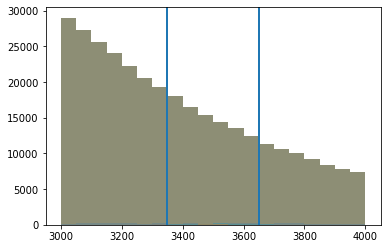

In [22]:
# Fit with full dataset, no cuts
#mask_sr=[3,4]
#def fit_func(y,p0,p1,p2,p3,p4,p5,p6,p7):
#    return np.exp(p0+p1*y+p2*y**2+p3*y**3+p4*y**4+p5*y**5+p6*y**6+p7*y**7)
#def fit_func(x,p0,p1,p2,p3,p4,p5,p6):
#    return (p3+p4*x+p5*x**2+p6*x**3)*skewnorm.pdf((x-p0)/p1,p2)\
#def fit_func(x,p0,p1,p2,p3,p4):
#    return p0*(1-x)**(p1+p4*(np.log(1-x)))/(x**(p2+p3*np.log(x)))

def fit_func(x,p0,p1):
    return p0+p1*x

pvallist_cut_sig=[]
pvallist_cut_sig2=[]
info_m500_cut_1 = []
info_m300_cut_1 = []

nbins=20
mask_sr=[7,8,9,10,11,12]
mask_sb=[x for x in range(nbins) if x not in mask_sr] 

nback = len(mjj_bg)

for nsig in range(10,895,15):
    print(nsig)
    
    ##########  m = 500 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig_raw,bins,_=plt.hist(mjj_sig[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 1% of all the events survive
    n_cut = int((nback + nsig)*0.99)
    mse_sorted = np.sort(np.concatenate((mse_bg_final_avg, mse_sig_final_avg[:nsig]), axis=0))
    cut_1_mse_m500 = mse_sorted[n_cut]
    
    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_1_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig,bins,_=plt.hist(mjj_sig[:nsig][mse_sig_final_avg[:nsig]>cut_1_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])

    # After cut: define the total number of events (s+b) in each SR bin, and the statistical error in each SR bin
    ydata=(counts_bg+counts_sig).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')

    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    # Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m500 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m500_cut_1.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m500])
    
    ##########  m = 300 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2_raw,bins,_=plt.hist(mjj_sig2[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig2_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 1% of all the events survive
    n_cut = int((nback + nsig)*0.99)
    mse_sorted = np.sort(np.concatenate((mse_bg_final_avg, mse_sig2_final_avg[:nsig]), axis=0))
    cut_1_mse_m300 = mse_sorted[n_cut]

    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_1_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2,bins,_=plt.hist(mjj_sig2[:nsig][mse_sig2_final_avg[:nsig]>cut_1_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig2[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])
    
    # After cut: define the total number of events (s+b) in each bin, and the statistical error in each bin
    ydata=(counts_bg+counts_sig2).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig2).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')
    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    #Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig2.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m300 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m300_cut_1.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m300])

# Transform lists to arrays
info_m500_cut_1 = np.array(info_m500_cut_1)
info_m300_cut_1 = np.array(info_m300_cut_1)

In [23]:
print('Event selection for m500: %.2f%%' % selection_m500)
print('Event selection for m300: %.2f%%' % selection_m300)

Event selection for m500: 1.50%
Event selection for m300: 1.45%


Text(0, 0.5, 'p value')

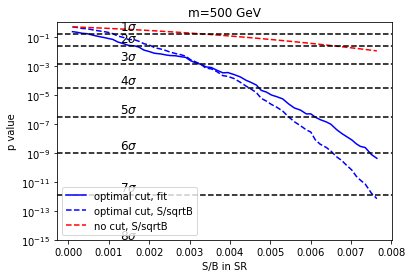

In [24]:
# Make plot
plt.plot(info_m500_cut_1[:,0], info_m500_cut_1[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m500_cut_1[:,0], info_m500_cut_1[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m500_cut_1[:,0], info_m500_cut_1[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=500 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

Text(0, 0.5, 'p value')

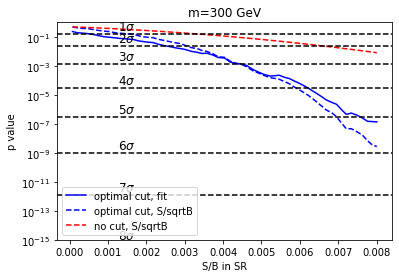

In [25]:
# Make plot
plt.plot(info_m300_cut_1[:,0], info_m300_cut_1[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m300_cut_1[:,0], info_m300_cut_1[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m300_cut_1[:,0], info_m300_cut_1[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=300 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

In [26]:
# Check the fraction of selected events in the SR for each benchmarks for the m500 signal
info_m500_cut_1[:,-1]

array([1.27846407, 1.28162597, 1.28590699, 1.28794747, 1.29438033,
       1.29862953, 1.30178692, 1.30495796, 1.30812829, 1.31679242,
       1.32100688, 1.32529322, 1.32619258, 1.33046263, 1.33692496,
       1.34005939, 1.34429667, 1.34629603, 1.34944279, 1.35151535,
       1.35242466, 1.35446654, 1.35649297, 1.3629597 , 1.36718965,
       1.37031607, 1.37566138, 1.37658158, 1.38080755, 1.3861037 ,
       1.38593573, 1.38902658, 1.39321784, 1.39852439, 1.40168907,
       1.40697764, 1.41451279, 1.4176435 , 1.42185832, 1.4238713 ,
       1.42696827, 1.4333645 , 1.43865901, 1.44173668, 1.44592886,
       1.44686933, 1.45110757, 1.45532888, 1.45840202, 1.46043956,
       1.46572468, 1.46884338, 1.47305981, 1.477259  , 1.48258783,
       1.48573562, 1.48775212, 1.49520809, 1.49940178])

In [27]:
# Check the fraction of selected events in the SR for each benchmarks for the m300 signal
info_m300_cut_1[:,-1]

array([1.27849235, 1.28385178, 1.28589277, 1.28790475, 1.29216961,
       1.2964191 , 1.29954803, 1.30157117, 1.30360812, 1.30564454,
       1.30765153, 1.30861144, 1.30958559, 1.31382832, 1.31590568,
       1.31790989, 1.31885354, 1.32416715, 1.32728717, 1.32930314,
       1.33240683, 1.33443617, 1.33756768, 1.3418009 , 1.34379857,
       1.34694237, 1.34676424, 1.35097907, 1.35629448, 1.35717197,
       1.36467271, 1.36779622, 1.36868648, 1.37179346, 1.37818678,
       1.38130668, 1.38548052, 1.38856797, 1.38838466, 1.3882472 ,
       1.39136365, 1.39337952, 1.39760944, 1.40075425, 1.40495141,
       1.40916286, 1.41445669, 1.42081667, 1.42610721, 1.42919917,
       1.43122329, 1.43764003, 1.44403936, 1.44384909, 1.44582281,
       1.44892538, 1.45312466, 1.45403068, 1.4549684 ])

In [28]:
###################################################################################################################
###################################################################################################################
##################################################               ##################################################
##################################################     Cut 2     ##################################################
##################################################               ##################################################
###################################################################################################################
###################################################################################################################

10
fit params:  [-18.21798993 114.6913345 ]
x_signal_cov:  [[26.05986766]]
Z SCORE:  2.2271636102681236
P VALUE:  0.012968170595422768
GOODNESS OF FIT  0.9693489921321178
fit params:  [-17.00611986 110.22543645]
x_signal_cov:  [[25.53907791]]
Z SCORE:  2.0780464279070987
P VALUE:  0.018852541570606784
GOODNESS OF FIT  0.9413875224739858
25
fit params:  [-18.21798993 114.6913345 ]
x_signal_cov:  [[26.05986766]]
Z SCORE:  2.3216036379939458
P VALUE:  0.010127143914905434
GOODNESS OF FIT  0.9693489921321178
fit params:  [-18.21798993 114.6913345 ]
x_signal_cov:  [[26.05986766]]
Z SCORE:  2.2271636102681236
P VALUE:  0.012968170595422768
GOODNESS OF FIT  0.9693489921321178
40
fit params:  [-18.21798993 114.6913345 ]
x_signal_cov:  [[26.05986766]]
Z SCORE:  2.4156276440562494
P VALUE:  0.007854057855337326
GOODNESS OF FIT  0.9693489921321178
fit params:  [-18.21798993 114.6913345 ]
x_signal_cov:  [[26.05986766]]
Z SCORE:  2.2271636102681236
P VALUE:  0.012968170595422768
GOODNESS OF FIT  0.

fit params:  [-20.11476835 122.48407533]
x_signal_cov:  [[29.07040575]]
Z SCORE:  2.8014034406772454
P VALUE:  0.0025440432656607115
GOODNESS OF FIT  1.0760411088209376
385
fit params:  [-18.83158678 116.4557345 ]
x_signal_cov:  [[22.13747611]]
Z SCORE:  5.208498307942236
P VALUE:  9.518754362503046e-08
GOODNESS OF FIT  0.8372619807444462
fit params:  [-19.89001483 121.47206578]
x_signal_cov:  [[27.63493172]]
Z SCORE:  2.931476035104046
P VALUE:  0.0016867769692886503
GOODNESS OF FIT  1.0256647530757506
400
fit params:  [-18.83158678 116.4557345 ]
x_signal_cov:  [[22.13747611]]
Z SCORE:  5.208498307942236
P VALUE:  9.518754362503046e-08
GOODNESS OF FIT  0.8372619807444462
fit params:  [-19.89001483 121.47206578]
x_signal_cov:  [[27.63493172]]
Z SCORE:  2.931476035104046
P VALUE:  0.0016867769692886503
GOODNESS OF FIT  1.0256647530757506
415
fit params:  [-18.83158678 116.4557345 ]
x_signal_cov:  [[22.13747611]]
Z SCORE:  5.208498307942236
P VALUE:  9.518754362503046e-08
GOODNESS OF FIT

fit params:  [-19.91570652 121.31045006]
x_signal_cov:  [[25.06290859]]
Z SCORE:  4.092979401814088
P VALUE:  2.129327822408822e-05
GOODNESS OF FIT  0.9361096900229734
760
fit params:  [-18.56793259 115.02422303]
x_signal_cov:  [[20.44816648]]
Z SCORE:  7.24658464220952
P VALUE:  2.1371793224034263e-13
GOODNESS OF FIT  0.7805229921504779
fit params:  [-19.91570652 121.31045006]
x_signal_cov:  [[25.06290859]]
Z SCORE:  4.092979401814088
P VALUE:  2.129327822408822e-05
GOODNESS OF FIT  0.9361096900229734
775
fit params:  [-18.56793259 115.02422303]
x_signal_cov:  [[20.44816648]]
Z SCORE:  7.327262909239363
P VALUE:  1.1746159600534156e-13
GOODNESS OF FIT  0.7805229921504779
fit params:  [-19.91570652 121.31045006]
x_signal_cov:  [[25.06290859]]
Z SCORE:  4.092979401814088
P VALUE:  2.129327822408822e-05
GOODNESS OF FIT  0.9361096900229734
790
fit params:  [-18.56793259 115.02422303]
x_signal_cov:  [[20.44816648]]
Z SCORE:  7.327262909239363
P VALUE:  1.1746159600534156e-13
GOODNESS OF FI

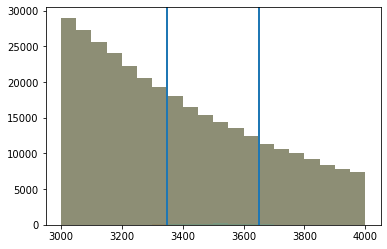

In [29]:
# Fit with full dataset, no cuts
#mask_sr=[3,4]
#def fit_func(y,p0,p1,p2,p3,p4,p5,p6,p7):
#    return np.exp(p0+p1*y+p2*y**2+p3*y**3+p4*y**4+p5*y**5+p6*y**6+p7*y**7)
#def fit_func(x,p0,p1,p2,p3,p4,p5,p6):
#    return (p3+p4*x+p5*x**2+p6*x**3)*skewnorm.pdf((x-p0)/p1,p2)\
#def fit_func(x,p0,p1,p2,p3,p4):
#    return p0*(1-x)**(p1+p4*(np.log(1-x)))/(x**(p2+p3*np.log(x)))

def fit_func(x,p0,p1):
    return p0+p1*x

pvallist_cut_sig=[]
pvallist_cut_sig2=[]
info_m500_cut_2 = []
info_m300_cut_2 = []

nbins=20
mask_sr=[7,8,9,10,11,12]
mask_sb=[x for x in range(nbins) if x not in mask_sr] 

nback = len(mjj_bg)

for nsig in range(10,895,15):
    print(nsig)
    
    ##########  m = 500 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig_raw,bins,_=plt.hist(mjj_sig[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 0.1% of all the events survive
    n_cut = int((nback + nsig)*0.999)
    mse_sorted = np.sort(np.concatenate((mse_bg_final_avg, mse_sig_final_avg[:nsig]), axis=0))
    cut_2_mse_m500 = mse_sorted[n_cut]
    
    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_2_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig,bins,_=plt.hist(mjj_sig[:nsig][mse_sig_final_avg[:nsig]>cut_2_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])

    # After cut: define the total number of events (s+b) in each SR bin, and the statistical error in each SR bin
    ydata=(counts_bg+counts_sig).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')

    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    # Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m500 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m500_cut_2.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m500])
    
    ##########  m = 300 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2_raw,bins,_=plt.hist(mjj_sig2[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig2_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 0.1% of all the events survive
    n_cut = int((nback + nsig)*0.999)
    mse_sorted = np.sort(np.concatenate((mse_bg_final_avg, mse_sig2_final_avg[:nsig]), axis=0))
    cut_2_mse_m300 = mse_sorted[n_cut]

    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_2_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2,bins,_=plt.hist(mjj_sig2[:nsig][mse_sig2_final_avg[:nsig]>cut_2_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig2[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])
    
    # After cut: define the total number of events (s+b) in each bin, and the statistical error in each bin
    ydata=(counts_bg+counts_sig2).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig2).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')
    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    #Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig2.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m300 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m300_cut_2.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m300])

# Transform lists to arrays
info_m500_cut_2 = np.array(info_m500_cut_2)
info_m300_cut_2 = np.array(info_m300_cut_2)

In [30]:
print('Event selection for m500: %.2f%%' % selection_m500)
print('Event selection for m300: %.2f%%' % selection_m300)

Event selection for m500: 0.16%
Event selection for m300: 0.12%


Text(0, 0.5, 'p value')

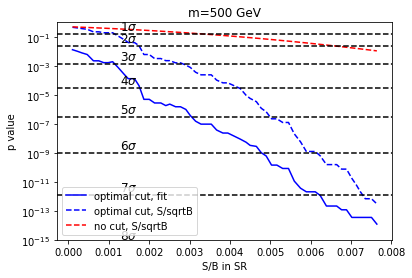

In [31]:
# Make plot
plt.plot(info_m500_cut_2[:,0], info_m500_cut_2[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m500_cut_2[:,0], info_m500_cut_2[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m500_cut_2[:,0], info_m500_cut_2[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=500 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

Text(0, 0.5, 'p value')

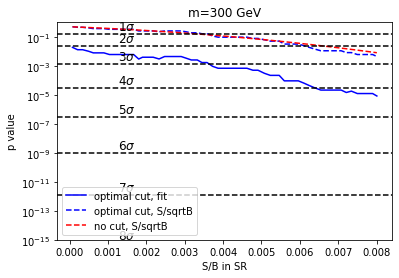

In [32]:
# Make plot
plt.plot(info_m300_cut_2[:,0], info_m300_cut_2[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m300_cut_2[:,0], info_m300_cut_2[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m300_cut_2[:,0], info_m300_cut_2[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=300 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

In [33]:
# Check the fraction of selected events in the SR for each benchmarks for the m500 signal
info_m500_cut_2[:,-1]

array([0.09400471, 0.09509908, 0.09619425, 0.09728702, 0.10058805,
       0.10057471, 0.10166757, 0.10165634, 0.1016451 , 0.1049457 ,
       0.10824304, 0.1104411 , 0.11042403, 0.11262007, 0.11812632,
       0.11811067, 0.12030241, 0.12028383, 0.12137261, 0.12136056,
       0.12244628, 0.12243142, 0.12351806, 0.12460716, 0.12679581,
       0.12788147, 0.12786596, 0.12784905, 0.13003615, 0.13111792,
       0.13110203, 0.13218334, 0.13326431, 0.13434644, 0.13543422,
       0.13651426, 0.13869931, 0.13978317, 0.14196573, 0.14194698,
       0.14302689, 0.14300644, 0.14628566, 0.14846259, 0.14954093,
       0.14952449, 0.14950805, 0.15058917, 0.15276404, 0.15274725,
       0.15272543, 0.15380559, 0.153787  , 0.1559634 , 0.15594628,
       0.15593086, 0.15591203, 0.15588807, 0.15696519])

In [34]:
# Check the fraction of selected events in the SR for each benchmarks for the m300 signal
info_m300_cut_2[:,-1]

array([0.09290083, 0.09399432, 0.09398184, 0.0950728 , 0.0961666 ,
       0.09615385, 0.09614003, 0.09723112, 0.09721823, 0.09720535,
       0.09719032, 0.09717958, 0.09716993, 0.09936517, 0.09935529,
       0.09933994, 0.09932788, 0.10041601, 0.09929829, 0.09928405,
       0.09926872, 0.09925558, 0.10034514, 0.10143441, 0.10141876,
       0.10250871, 0.10249515, 0.10468435, 0.10577114, 0.10575366,
       0.10573735, 0.10572338, 0.10570708, 0.10569195, 0.10677645,
       0.10676235, 0.10784519, 0.10892887, 0.10891449, 0.1089037 ,
       0.11108911, 0.11107445, 0.11106102, 0.11104881, 0.11213227,
       0.11321667, 0.11429953, 0.11537954, 0.11536306, 0.11534659,
       0.11533265, 0.11531872, 0.11640165, 0.11638631, 0.11746624,
       0.11745077, 0.1174353 , 0.11741984, 0.11850421])

In [35]:
###################################################################################################################
###################################################################################################################
##################################################               ##################################################
##################################################     Cut 3     ##################################################
##################################################               ##################################################
###################################################################################################################
###################################################################################################################

10
mse threshold: 1.66464
9.0
90412.0
fit params:  [141.45637396  23.15667693]
x_signal_cov:  [[238.61330681]]
Z SCORE:  0.5805432760869087
P VALUE:  0.2807741559643828
GOODNESS OF FIT  0.6301994659211902
fit params:  [141.45637396  23.15667693]
x_signal_cov:  [[238.61330681]]
Z SCORE:  0.5805432760869087
P VALUE:  0.2807741559643828
GOODNESS OF FIT  0.6301994659211902
25
mse threshold: 1.66589
20.0
90412.0
fit params:  [142.99332267  16.16084839]
x_signal_cov:  [[237.26532702]]
Z SCORE:  0.618917632145682
P VALUE:  0.26798531111357315
GOODNESS OF FIT  0.6275428880458342
fit params:  [142.59465972  17.49758421]
x_signal_cov:  [[234.09713981]]
Z SCORE:  0.6313820503327777
P VALUE:  0.2638953747887107
GOODNESS OF FIT  0.6194349961222021
40
mse threshold: 1.66831
30.0
90412.0
fit params:  [1.46020388e+02 1.41933829e-01]
x_signal_cov:  [[225.90035452]]
Z SCORE:  0.7986508888366443
P VALUE:  0.2122464355555469
GOODNESS OF FIT  0.6014830921138778
fit params:  [145.74934107   2.90221659]
x_si

fit params:  [131.86629888  37.16693911]
x_signal_cov:  [[205.31021077]]
Z SCORE:  1.7673697819339507
P VALUE:  0.038583160104594616
GOODNESS OF FIT  0.5656274563876935
355
mse threshold: 1.69175
273.0
90412.0
fit params:  [113.58180317  91.9969092 ]
x_signal_cov:  [[200.93722369]]
Z SCORE:  2.6270914271873553
P VALUE:  0.004305909598574464
GOODNESS OF FIT  0.5721310861072552
fit params:  [131.68252755  37.11199477]
x_signal_cov:  [[197.92760706]]
Z SCORE:  1.8103773649063044
P VALUE:  0.035118643495875346
GOODNESS OF FIT  0.5460524909314783
370
mse threshold: 1.69327
285.0
90412.0
fit params:  [113.87981807  88.78387161]
x_signal_cov:  [[202.33487643]]
Z SCORE:  2.720443341085901
P VALUE:  0.003259722165587786
GOODNESS OF FIT  0.5782497189747965
fit params:  [132.70799826  32.69585881]
x_signal_cov:  [[200.83283304]]
Z SCORE:  1.8525877373592834
P VALUE:  0.03197073570497333
GOODNESS OF FIT  0.5543765462020966
385
mse threshold: 1.69365
297.0
90412.0
fit params:  [114.33314767  86.226

fit params:  [ 83.879872   156.01044065]
x_signal_cov:  [[95.98657551]]
Z SCORE:  5.686700968012394
P VALUE:  6.475847524889389e-09
GOODNESS OF FIT  0.3037708195140468
fit params:  [106.99135668  97.19678326]
x_signal_cov:  [[166.8964991]]
Z SCORE:  3.788525925110514
P VALUE:  7.577189050567146e-05
GOODNESS OF FIT  0.49435540473434375
700
mse threshold: 1.72526
553.0
90412.0
fit params:  [ 85.10409302 150.56015045]
x_signal_cov:  [[94.21938873]]
Z SCORE:  5.722220194616592
P VALUE:  5.257045687656614e-09
GOODNESS OF FIT  0.29851425483053445
fit params:  [105.27019034  99.61061135]
x_signal_cov:  [[155.65498318]]
Z SCORE:  4.031495524534774
P VALUE:  2.7711526071283465e-05
GOODNESS OF FIT  0.46501629714228654
715
mse threshold: 1.72656
564.0
90412.0
fit params:  [ 83.00223489 156.57689678]
x_signal_cov:  [[77.2028306]]
Z SCORE:  5.9123056633084925
P VALUE:  1.6867587326885314e-09
GOODNESS OF FIT  0.24579773296109678
fit params:  [104.29122142 100.69585447]
x_signal_cov:  [[152.23467996]

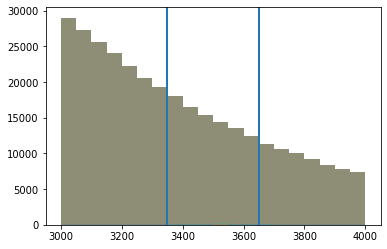

In [37]:
# Fit with full dataset, no cuts
#mask_sr=[3,4]
#def fit_func(y,p0,p1,p2,p3,p4,p5,p6,p7):
#    return np.exp(p0+p1*y+p2*y**2+p3*y**3+p4*y**4+p5*y**5+p6*y**6+p7*y**7)
#def fit_func(x,p0,p1,p2,p3,p4,p5,p6):
#    return (p3+p4*x+p5*x**2+p6*x**3)*skewnorm.pdf((x-p0)/p1,p2)\
#def fit_func(x,p0,p1,p2,p3,p4):
#    return p0*(1-x)**(p1+p4*(np.log(1-x)))/(x**(p2+p3*np.log(x)))

def fit_func(x,p0,p1):
    return p0+p1*x

pvallist_cut_sig=[]
pvallist_cut_sig2=[]
info_m500_cut_3 = []
info_m300_cut_3 = []
SIC_info_m500_cut_3 = []
SIC_info_m300_cut_3 = []

nbins=20
mask_sr=[7,8,9,10,11,12]
mask_sb=[x for x in range(nbins) if x not in mask_sr] 

nback = len(mjj_bg)

for nsig in range(10,895,15):
    print(nsig)
    
    ##########  m = 500 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig_raw,bins,_=plt.hist(mjj_sig[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.99)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig_final_avg[:nsig][(mjj_sig[:nsig] > 3350) & (mjj_sig[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_3_mse_m500 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m500 = np.abs(SIC_m500 - maxsiccut_sig).argmin()
    #eff_m500 = tpr500[:up_bound_m500][np.abs(SIC_m500[:up_bound_m500] - cut_3_mse_m500).argmin()]
    
    eff_m500 = tpr500[np.abs(thresh_m500 - cut_3_mse_m500).argmin()]
    SIC_1_percent_m500 = SIC_m500[np.abs(thresh_m500 - cut_3_mse_m500).argmin()]
    
    print('mse threshold: %.5f' % cut_3_mse_m500)
    print(Sinit)
    print(Binit)
    
    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_3_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig,bins,_=plt.hist(mjj_sig[:nsig][mse_sig_final_avg[:nsig]>cut_3_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])

    # After cut: define the total number of events (s+b) in each SR bin, and the statistical error in each SR bin
    ydata=(counts_bg+counts_sig).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')

    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    # Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m500 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m500_cut_3.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m500])
    SIC_info_m500_cut_3.append([S_B, eff_m500, SIC_1_percent_m500])
    
    
    ##########  m = 300 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2_raw,bins,_=plt.hist(mjj_sig2[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig2_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.99)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig2_final_avg[:nsig][(mjj_sig2[:nsig] > 3350) & (mjj_sig2[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_3_mse_m300 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m300 = np.abs(SIC_m300 - maxsiccut_sig).argmin()
    #eff_m300 = tpr300[:up_bound_m300][np.abs(SIC_m300[:up_bound_m300] - cut_3_mse_m300).argmin()]
    
    eff_m300 = tpr300[np.abs(thresh_m300 - cut_3_mse_m300).argmin()]
    SIC_1_percent_m300 = SIC_m300[np.abs(thresh_m300 - cut_3_mse_m300).argmin()]

    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_3_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2,bins,_=plt.hist(mjj_sig2[:nsig][mse_sig2_final_avg[:nsig]>cut_3_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig2[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])
    
    # After cut: define the total number of events (s+b) in each bin, and the statistical error in each bin
    ydata=(counts_bg+counts_sig2).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig2).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')
    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    #Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig2.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m300 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m300_cut_3.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m300])
    SIC_info_m300_cut_3.append([S_B, eff_m300, SIC_1_percent_m300])
    
# Transform lists to arrays
info_m500_cut_3 = np.array(info_m500_cut_3)
info_m300_cut_3 = np.array(info_m300_cut_3)
SIC_info_m500_cut_3 = np.array(SIC_info_m500_cut_3)
SIC_info_m300_cut_3 = np.array(SIC_info_m300_cut_3)

In [37]:
print('Event selection for m500: %.2f%%' % selection_m500)
print('Event selection for m300: %.2f%%' % selection_m300)

Event selection for m500: 1.00%
Event selection for m300: 1.00%


In [38]:
print('Signal efficiency for this cut on m500:\n%s\n' % SIC_info_m500_cut_3[:,1])
print('Signal efficiency for this cut on m300:\n%s' % SIC_info_m300_cut_3[:,1])

Signal efficiency for this cut on m500:
[0.29990287 0.29901247 0.29809894 0.2979833  0.29741668 0.29716228
 0.29676912 0.29667661 0.29648003 0.29572839 0.29519647 0.29465298
 0.29459516 0.29441014 0.29388978 0.29343879 0.2926409  0.29249058
 0.29227087 0.29205116 0.29191239 0.29147298 0.29087167 0.28987719
 0.28936839 0.28927589 0.28868614 0.28851269 0.28816578 0.28683596
 0.28669719 0.28629247 0.28528643 0.28451167 0.28434978 0.28374847
 0.28267305 0.28225676 0.28189829 0.28164389 0.28062629 0.28011749
 0.27952774 0.27888018 0.27851014 0.27793196 0.27748098 0.27712251
 0.27645181 0.27578112 0.27554985 0.27544578 0.27485603 0.27440505
 0.27391938 0.27366498 0.27335276 0.27261269 0.27228891]

Signal efficiency for this cut on m300:
[0.24748901 0.24671554 0.2464353  0.24615505 0.24552731 0.24525827
 0.24496682 0.24496682 0.24417093 0.24415972 0.24415972 0.24392431
 0.24385705 0.24364407 0.24327415 0.24308358 0.24308358 0.24254551
 0.24197381 0.24181688 0.24153663 0.24132365 0.240808   0.

In [39]:
print('SIC value for this cut on m500:\n%s\n' % SIC_info_m500_cut_3[:,2])
print('SIC value for this cut on m300:\n%s' % SIC_info_m300_cut_3[:,2])

SIC value for this cut on m500:
[3.016109   3.01453963 3.01905828 3.01809029 3.01886793 3.02131214
 3.02200764 3.02318439 3.02933905 3.03465115 3.03954707 3.04395593
 3.04159488 3.04394562 3.04799707 3.04702304 3.04965806 3.04966313
 3.05095657 3.05433212 3.05612669 3.05694428 3.05862079 3.05783236
 3.05809206 3.06147595 3.06672621 3.07016136 3.07151829 3.07224559
 3.07258646 3.07547585 3.06925737 3.06681543 3.06946374 3.06927767
 3.07361961 3.0756008  3.07963083 3.08089968 3.0817056  3.08046705
 3.08517306 3.08709708 3.08784653 3.08941608 3.09333314 3.09517896
 3.09714485 3.09444662 3.09830032 3.10062865 3.10113742 3.10290701
 3.10549418 3.10992588 3.10877424 3.10660595 3.11047328]

SIC value for this cut on m300:
[2.48911486 2.48888034 2.4892466  2.49053262 2.48733825 2.48763066
 2.48810852 2.48810852 2.48779589 2.48794871 2.48794871 2.49058368
 2.49043864 2.49448891 2.4946322  2.4973629  2.4973629  2.4987767
 2.50241823 2.4991804  2.50034387 2.499887   2.50124995 2.49858802
 2.49935

In [40]:
print('Threshold based on the SIC curve: mse = %.3f' % cut_3_mse_m500)
print('Threshold based on the SIC curve: mse = %.3f' % cut_3_mse_m300)

Threshold based on the SIC curve: mse = 1.739
Threshold based on the SIC curve: mse = 1.723


Text(0, 0.5, 'p value')

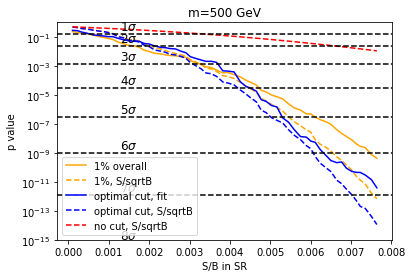

In [41]:
# Make plot
plt.plot(info_m500_cut_1[:,0], info_m500_cut_1[:,3], label='1% overall',color='orange')
plt.plot(info_m500_cut_1[:,0], info_m500_cut_1[:,5], label='1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m500_cut_3[:,0], info_m500_cut_3[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m500_cut_3[:,0], info_m500_cut_3[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m500_cut_3[:,0], info_m500_cut_3[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=500 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

Text(0, 0.5, 'p value')

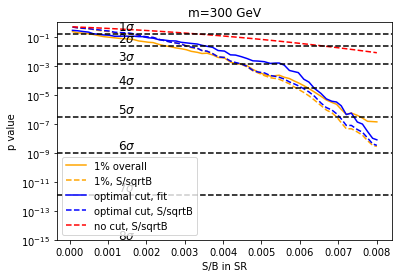

In [42]:
# Make plot
plt.plot(info_m300_cut_1[:,0], info_m300_cut_1[:,3], label='1% overall',color='orange')
plt.plot(info_m300_cut_1[:,0], info_m300_cut_1[:,5], label='1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m300_cut_3[:,0], info_m300_cut_3[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m300_cut_3[:,0], info_m300_cut_3[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m300_cut_3[:,0], info_m300_cut_3[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=300 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

In [43]:
# Check the fraction of selected events in the SR for each benchmarks for the m500 signal
info_m500_cut_3[:,-1]

array([0.99866182, 0.99854034, 0.99842993, 0.99829748, 0.99814299,
       0.99801061, 0.99788929, 0.99888399, 0.99877363, 0.99864123,
       0.99848681, 0.99838756, 0.99823322, 0.998123  , 0.99800179,
       0.99786959, 0.99884112, 0.99868681, 0.9985656 , 0.99846644,
       0.99832326, 0.99820213, 0.99807003, 0.99795997, 0.99782793,
       0.99879836, 0.99867725, 0.99854517, 0.99841312, 0.99825911,
       0.99813813, 0.9979842 , 0.99783032, 0.99878868, 0.9986897 ,
       0.99853577, 0.99841487, 0.99829398, 0.99816215, 0.99803035,
       0.9978876 , 0.99884495, 0.99870213, 0.99854837, 0.99840563,
       0.99829586, 0.99818612, 0.99806542, 0.99791186, 0.9978022 ,
       0.99875842, 0.99863772, 0.99851705, 0.99838545, 0.99827581,
       0.99817715, 0.99805659, 0.9979032 , 0.99886941])

In [44]:
# Check the fraction of selected events in the SR for each benchmarks for the m300 signal
info_m300_cut_3[:,-1]

array([0.9986839 , 0.99855138, 0.99841889, 0.99826437, 0.99814299,
       0.99801061, 0.99786724, 0.99882881, 0.99869639, 0.99856401,
       0.99840961, 0.99829936, 0.99820015, 0.9980679 , 0.99796874,
       0.99781452, 0.99879703, 0.99864273, 0.99849949, 0.9983563 ,
       0.99820213, 0.99807003, 0.99793796, 0.99780593, 0.99875431,
       0.99863322, 0.99850115, 0.99835811, 0.99821511, 0.99805017,
       0.99789627, 0.99886568, 0.99871169, 0.99856875, 0.99841487,
       0.998283  , 0.99811821, 0.99796446, 0.99783271, 0.99883396,
       0.99870213, 0.99857033, 0.99844954, 0.99833977, 0.99819709,
       0.99806542, 0.99792283, 0.99885719, 0.99871453, 0.9985719 ,
       0.99845125, 0.99833062, 0.99819907, 0.99806755, 0.99791415,
       0.99888038, 0.99874882, 0.9986173 , 0.99850772])

In [21]:
###################################################################################################################
###################################################################################################################
##################################################               ##################################################
##################################################     Cut 4     ##################################################
##################################################               ##################################################
###################################################################################################################
###################################################################################################################

10
fit params:  [-16.16130465 110.43362563]
x_signal_cov:  [[33.70495278]]
Z SCORE:  1.910093600605338
P VALUE:  0.028060581410034313
GOODNESS OF FIT  1.1450479637181097
fit params:  [-15.71710915 108.95686974]
x_signal_cov:  [[33.80212294]]
Z SCORE:  1.8652251642830326
P VALUE:  0.031074924850344576
GOODNESS OF FIT  1.1408736729430757
25
fit params:  [-15.84341575 108.93949593]
x_signal_cov:  [[33.00166978]]
Z SCORE:  1.949386503110868
P VALUE:  0.02562464256425656
GOODNESS OF FIT  1.126632068996081
fit params:  [-16.16130465 110.43362563]
x_signal_cov:  [[33.70495278]]
Z SCORE:  1.910093600605338
P VALUE:  0.028060581410034313
GOODNESS OF FIT  1.1450479637181097
40
fit params:  [-16.56589345 110.51777588]
x_signal_cov:  [[28.71060968]]
Z SCORE:  2.190618694949814
P VALUE:  0.014239698569159187
GOODNESS OF FIT  1.0091910531173576
fit params:  [-16.16130465 110.43362563]
x_signal_cov:  [[33.70495278]]
Z SCORE:  1.910093600605338
P VALUE:  0.028060581410034313
GOODNESS OF FIT  1.1450479

fit params:  [-17.91053996 112.04644894]
x_signal_cov:  [[20.7468561]]
Z SCORE:  2.9165558490162193
P VALUE:  0.0017695967744140173
GOODNESS OF FIT  0.7987490107385814
400
fit params:  [-12.34610127  80.76009198]
x_signal_cov:  [[15.43868044]]
Z SCORE:  4.651478518001255
P VALUE:  1.647818050676264e-06
GOODNESS OF FIT  0.7654246422819608
fit params:  [-17.91053996 112.04644894]
x_signal_cov:  [[20.7468561]]
Z SCORE:  2.9165558490162193
P VALUE:  0.0017695967744140173
GOODNESS OF FIT  0.7987490107385814
415
fit params:  [-12.34610127  80.76009198]
x_signal_cov:  [[15.43868044]]
Z SCORE:  4.651478518001255
P VALUE:  1.647818050676264e-06
GOODNESS OF FIT  0.7654246422819608
fit params:  [-17.91053996 112.04644894]
x_signal_cov:  [[20.7468561]]
Z SCORE:  2.9165558490162193
P VALUE:  0.0017695967744140173
GOODNESS OF FIT  0.7987490107385814
430
fit params:  [-12.59599548  81.63631514]
x_signal_cov:  [[14.42658022]]
Z SCORE:  4.713071465932423
P VALUE:  1.2200528495265317e-06
GOODNESS OF FIT

fit params:  [-13.12570049  79.22105656]
x_signal_cov:  [[6.42112564]]
Z SCORE:  6.186049779512978
P VALUE:  3.0845270782009493e-10
GOODNESS OF FIT  0.3738424174249321
fit params:  [-18.58351214 112.38575546]
x_signal_cov:  [[22.05441587]]
Z SCORE:  3.3782038127350096
P VALUE:  0.0003648049141301568
GOODNESS OF FIT  0.9015854904255396
775
fit params:  [-13.12570049  79.22105656]
x_signal_cov:  [[6.42112564]]
Z SCORE:  6.186049779512978
P VALUE:  3.0845270782009493e-10
GOODNESS OF FIT  0.3738424174249321
fit params:  [-18.58351214 112.38575546]
x_signal_cov:  [[22.05441587]]
Z SCORE:  3.3782038127350096
P VALUE:  0.0003648049141301568
GOODNESS OF FIT  0.9015854904255396
790
fit params:  [-13.12570049  79.22105656]
x_signal_cov:  [[6.42112564]]
Z SCORE:  6.186049779512978
P VALUE:  3.0845270782009493e-10
GOODNESS OF FIT  0.3738424174249321
fit params:  [-19.58606494 116.15003117]
x_signal_cov:  [[21.62989881]]
Z SCORE:  3.42845577015567
P VALUE:  0.00030351271892237186
GOODNESS OF FIT  0

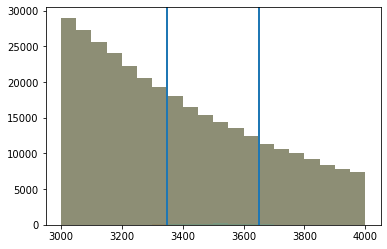

In [25]:
# Fit with full dataset, no cuts
#mask_sr=[3,4]
#def fit_func(y,p0,p1,p2,p3,p4,p5,p6,p7):
#    return np.exp(p0+p1*y+p2*y**2+p3*y**3+p4*y**4+p5*y**5+p6*y**6+p7*y**7)
#def fit_func(x,p0,p1,p2,p3,p4,p5,p6):
#    return (p3+p4*x+p5*x**2+p6*x**3)*skewnorm.pdf((x-p0)/p1,p2)\
#def fit_func(x,p0,p1,p2,p3,p4):
#    return p0*(1-x)**(p1+p4*(np.log(1-x)))/(x**(p2+p3*np.log(x)))

def fit_func(x,p0,p1):
    return p0+p1*x

pvallist_cut_sig=[]
pvallist_cut_sig2=[]
info_m500_cut_4 = []
info_m300_cut_4 = []
SIC_info_m500_cut_4 = []
SIC_info_m300_cut_4 = []

nbins=20
mask_sr=[7,8,9,10,11,12]
mask_sb=[x for x in range(nbins) if x not in mask_sr] 

nback = len(mjj_bg)

for nsig in range(10,895,15):
    print(nsig)
    
    ##########  m = 500 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig_raw,bins,_=plt.hist(mjj_sig[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 0.1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.999)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig_final_avg[:nsig][(mjj_sig[:nsig] > 3350) & (mjj_sig[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_4_mse_m500 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m500 = np.abs(SIC_m500 - maxsiccut_sig).argmin()
    #eff_m500 = tpr500[:up_bound_m500][np.abs(SIC_m500[:up_bound_m500] - cut_4_mse_m500).argmin()]
    
    eff_m500 = tpr500[np.abs(thresh_m500 - cut_4_mse_m500).argmin()]
    SIC_1_percent_m500 = SIC_m500[np.abs(thresh_m500 - cut_4_mse_m500).argmin()]
    
    #print('mse threshold: %.5f' % cut_4_mse_m500)
    
    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_4_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig,bins,_=plt.hist(mjj_sig[:nsig][mse_sig_final_avg[:nsig]>cut_4_mse_m500],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])

    # After cut: define the total number of events (s+b) in each SR bin, and the statistical error in each SR bin
    ydata=(counts_bg+counts_sig).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')

    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    # Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m500 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m500_cut_4.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m500])
    SIC_info_m500_cut_4.append([S_B, eff_m500, SIC_1_percent_m500])
    
    
    ##########  m = 300 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2_raw,bins,_=plt.hist(mjj_sig2[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig2_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 0.1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.999)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig2_final_avg[:nsig][(mjj_sig2[:nsig] > 3350) & (mjj_sig2[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_4_mse_m300 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m300 = np.abs(SIC_m300 - maxsiccut_sig).argmin()
    #eff_m300 = tpr300[:up_bound_m300][np.abs(SIC_m300[:up_bound_m300] - cut_4_mse_m300).argmin()]
    
    eff_m300 = tpr300[np.abs(thresh_m300 - cut_4_mse_m300).argmin()]
    SIC_1_percent_m300 = SIC_m300[np.abs(thresh_m300 - cut_4_mse_m300).argmin()]

    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_4_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2,bins,_=plt.hist(mjj_sig2[:nsig][mse_sig2_final_avg[:nsig]>cut_4_mse_m300],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig2[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])
    
    # After cut: define the total number of events (s+b) in each bin, and the statistical error in each bin
    ydata=(counts_bg+counts_sig2).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig2).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')
    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    #Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig2.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m300 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m300_cut_4.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m300])
    SIC_info_m300_cut_4.append([S_B, eff_m300, SIC_1_percent_m300])
    
# Transform lists to arrays
info_m500_cut_4 = np.array(info_m500_cut_4)
info_m300_cut_4 = np.array(info_m300_cut_4)
SIC_info_m500_cut_4 = np.array(SIC_info_m500_cut_4)
SIC_info_m300_cut_4 = np.array(SIC_info_m300_cut_4)

In [47]:
print('Event selection for m500: %.2f%%' % selection_m500)
print('Event selection for m300: %.2f%%' % selection_m300)

Event selection for m500: 0.10%
Event selection for m300: 0.10%


In [48]:
print('Signal efficiency for this cut on m500:\n%s\n' % SIC_info_m500_cut_4[:,1])
print('Signal efficiency for this cut on m300:\n%s' % SIC_info_m300_cut_4[:,1])

Signal efficiency for this cut on m500:
[0.09348042 0.09233562 0.09179213 0.09042762 0.08361664 0.08361664
 0.08347788 0.08347788 0.08347788 0.08242559 0.08221744 0.08101482
 0.08101482 0.08037882 0.07777701 0.07777701 0.07574181 0.07574181
 0.07574181 0.07574181 0.07518675 0.07518675 0.07490923 0.0738685
 0.0738685  0.07349846 0.07349846 0.07349846 0.07349846 0.0731053
 0.0731053  0.07296653 0.0710701  0.07097759 0.07097759 0.07097759
 0.06909272 0.06904646 0.06864174 0.06864174 0.06864174 0.06864174
 0.06400472 0.06383126 0.06291774 0.06291774 0.06291774 0.06291774
 0.06214297 0.06214297 0.06291774 0.06291774 0.06291774 0.06026966
 0.06026966 0.06016559 0.06016559 0.06016559 0.06016559]

Signal efficiency for this cut on m300:
[0.05366111 0.05322393 0.05322393 0.05208053 0.05164335 0.05164335
 0.05164335 0.05035423 0.05035423 0.05035423 0.05035423 0.05035423
 0.05035423 0.04554524 0.04554524 0.04554524 0.04554524 0.04554524
 0.04554524 0.04554524 0.04554524 0.04554524 0.04482782 0.04

In [49]:
print('SIC value for this cut on m500:\n%s\n' % SIC_info_m500_cut_4[:,2])
print('SIC value for this cut on m300:\n%s' % SIC_info_m300_cut_4[:,2])

SIC value for this cut on m500:
[3.07256398 3.07644446 3.0625351  3.06340861 2.87963739 2.87963739
 2.86662484 2.86662484 2.86662484 2.90145243 2.9370018  2.94046173
 2.94046173 2.93801416 2.95702533 2.95702533 2.9741723  2.9741723
 2.9361737  2.9361737  2.9463709  2.9463709  2.94323222 2.95278357
 2.95278357 2.97214629 2.97214629 2.97214629 2.94814759 2.95287027
 2.95287027 2.95685305 2.93647253 2.95707961 2.95707961 2.9346377
 2.9323184  2.93691663 2.97127783 2.97127783 2.97127783 2.97127783
 3.01975707 2.87496863 2.91619252 2.91619252 2.91619252 2.90932467
 2.9347341  2.9347341  2.90932467 2.90932467 2.90932467 2.88931411
 2.88931411 2.91546228 2.82757526 2.82757526 2.82757526]

SIC value for this cut on m300:
[1.75376834 1.75637461 1.75637461 1.74362209 1.7229354  1.7229354
 1.7229354  1.71294647 1.71294647 1.71294647 1.71294647 1.71294647
 1.71294647 1.57350732 1.57350732 1.57350732 1.57350732 1.57350732
 1.57350732 1.57350732 1.57350732 1.57350732 1.55390011 1.56142509
 1.5614250

In [50]:
print('Threshold based on the SIC curve: mse = %.3f' % cut_4_mse_m500)
print('Threshold based on the SIC curve: mse = %.3f' % cut_4_mse_m300)

Threshold based on the SIC curve: mse = 2.720
Threshold based on the SIC curve: mse = 2.556


Text(0, 0.5, 'p value')

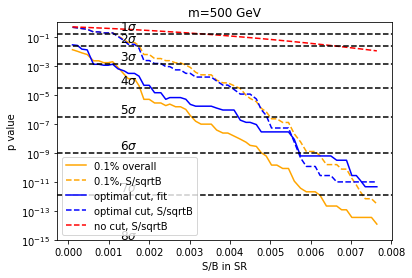

In [79]:
# Make plot
plt.plot(info_m500_cut_2[:,0], info_m500_cut_2[:,3], label='0.1% overall',color='orange')
plt.plot(info_m500_cut_2[:,0], info_m500_cut_2[:,5], label='0.1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m500_cut_4[:,0], info_m500_cut_4[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m500_cut_4[:,0], info_m500_cut_4[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m500_cut_4[:,0], info_m500_cut_4[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=500 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

Text(0, 0.5, 'p value')

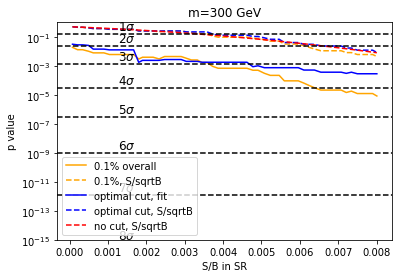

In [80]:
# Make plot
plt.plot(info_m300_cut_2[:,0], info_m300_cut_2[:,3], label='0.1% overall',color='orange')
plt.plot(info_m300_cut_2[:,0], info_m300_cut_2[:,5], label='0.1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m300_cut_4[:,0], info_m300_cut_4[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m300_cut_4[:,0], info_m300_cut_4[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m300_cut_4[:,0], info_m300_cut_4[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=300 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

In [53]:
# Check the fraction of selected events in the SR for each benchmarks for the m500 signal
info_m500_cut_4[:,-1]

array([0.09842846, 0.09841649, 0.09840561, 0.09839255, 0.09837733,
       0.09836428, 0.09835232, 0.09834145, 0.09833059, 0.09831755,
       0.09830235, 0.09829258, 0.09827739, 0.09826653, 0.0982546 ,
       0.09824159, 0.09822857, 0.0982134 , 0.09820148, 0.09819173,
       0.09817765, 0.09816573, 0.09815274, 0.09814192, 0.09812893,
       0.09811595, 0.09810406, 0.09809108, 0.09807811, 0.09806298,
       0.0980511 , 0.09803598, 0.09802086, 0.09800683, 0.09799712,
       0.09798201, 0.09797015, 0.09795829, 0.09794535, 0.09793242,
       0.09791841, 0.09790441, 0.09789041, 0.09787534, 0.09786134,
       0.09785059, 0.09783983, 0.097828  , 0.09781295, 0.0978022 ,
       0.09888697, 0.09887502, 0.09886307, 0.09885004, 0.09883919,
       0.09882942, 0.09881748, 0.0988023 , 0.09878928])

In [54]:
# Check the fraction of selected events in the SR for each benchmarks for the m300 signal
info_m300_cut_4[:,-1]

array([0.09843064, 0.09841758, 0.09840452, 0.09838929, 0.09837733,
       0.09836428, 0.09835015, 0.09833602, 0.09832299, 0.09830995,
       0.09829475, 0.0982839 , 0.09827413, 0.09826111, 0.09825135,
       0.09823616, 0.09822424, 0.09820906, 0.09819498, 0.0981809 ,
       0.09816573, 0.09815274, 0.09813976, 0.09812677, 0.09811163,
       0.09809973, 0.09808676, 0.09807271, 0.09805866, 0.09804246,
       0.09802734, 0.09801438, 0.09799927, 0.09798525, 0.09797015,
       0.09795721, 0.09794104, 0.09792595, 0.09791302, 0.09790333,
       0.09789041, 0.09787749, 0.09786565, 0.09785489, 0.0978409 ,
       0.097828  , 0.09781402, 0.09889675, 0.09888263, 0.0988685 ,
       0.09885656, 0.09884462, 0.09883159, 0.09881857, 0.09880338,
       0.09879037, 0.09877736, 0.09876435, 0.09875351])

In [55]:
###################################################################################################################
###################################################################################################################
##################################################               ##################################################
##################################################     Cut 5     ##################################################
##################################################               ##################################################
###################################################################################################################
###################################################################################################################

10
fit params:  [140.70704583   1.97430984]
x_signal_cov:  [[217.99397214]]
Z SCORE:  1.6891267674607569
P VALUE:  0.04559756960396699
GOODNESS OF FIT  1.0555218054290538
1.6646405
fit params:  [140.70704583   1.97430984]
x_signal_cov:  [[217.99397214]]
Z SCORE:  1.6891267674607569
P VALUE:  0.04559756960396699
GOODNESS OF FIT  1.0555218054290538
25
fit params:  [142.04869387  -4.70648193]
x_signal_cov:  [[218.15916312]]
Z SCORE:  1.7495095157749956
P VALUE:  0.04010149269280505
GOODNESS OF FIT  1.0584106644222686
1.6658908
fit params:  [141.88774254  -4.20817113]
x_signal_cov:  [[216.6545412]]
Z SCORE:  1.7574604802043678
P VALUE:  0.03941967614867137
GOODNESS OF FIT  1.0514031162369912
40
fit params:  [139.5231716    1.49860622]
x_signal_cov:  [[215.83406698]]
Z SCORE:  1.9314273241440243
P VALUE:  0.026715114399192497
GOODNESS OF FIT  1.054752556849641
1.6683084
fit params:  [140.31215441  -0.41612519]
x_signal_cov:  [[219.48892981]]
Z SCORE:  1.8708003671671074
P VALUE:  0.03068637

fit params:  [111.7476096   72.39300545]
x_signal_cov:  [[176.94910077]]
Z SCORE:  3.9579716452741116
P VALUE:  3.7794464094020874e-05
GOODNESS OF FIT  0.9358601374347078
1.693271
fit params:  [126.98630033  31.36022656]
x_signal_cov:  [[191.50211408]]
Z SCORE:  3.0027681806757123
P VALUE:  0.0013376806900617932
GOODNESS OF FIT  0.9727778070429884
385
fit params:  [111.65442609  72.401124  ]
x_signal_cov:  [[171.85450524]]
Z SCORE:  4.017161517542188
P VALUE:  2.945167661683179e-05
GOODNESS OF FIT  0.9095328464177381
1.6936504
fit params:  [125.27160522  36.274538  ]
x_signal_cov:  [[186.7951311]]
Z SCORE:  3.1027509379447435
P VALUE:  0.0009586546186549638
GOODNESS OF FIT  0.9526018651282058
400
fit params:  [110.74835151  73.78443198]
x_signal_cov:  [[173.04766765]]
Z SCORE:  4.1242746287745415
P VALUE:  1.8595247055608333e-05
GOODNESS OF FIT  0.9199600624513872
1.6953431
fit params:  [122.93193276  44.30188425]
x_signal_cov:  [[184.76167289]]
Z SCORE:  3.1696811734579917
P VALUE:  0

fit params:  [ 96.60210874 109.3020607 ]
x_signal_cov:  [[141.7558858]]
Z SCORE:  5.350764501655306
P VALUE:  4.379171847368468e-08
GOODNESS OF FIT  0.7874354691484123
730
fit params:  [ 82.12349601 139.97841979]
x_signal_cov:  [[105.64340999]]
Z SCORE:  6.876221456005665
P VALUE:  3.0730973321624333e-12
GOODNESS OF FIT  0.6222628815179244
1.7282557
fit params:  [ 95.07989686 112.80023281]
x_signal_cov:  [[133.82270334]]
Z SCORE:  5.508157301575174
P VALUE:  1.8130466128418732e-08
GOODNESS OF FIT  0.7474275052046205
745
fit params:  [ 81.69869863 140.02959261]
x_signal_cov:  [[103.15663989]]
Z SCORE:  6.975909442226434
P VALUE:  1.5194512315019892e-12
GOODNESS OF FIT  0.6097800724744439
1.7295122
fit params:  [ 95.3812473  110.31120931]
x_signal_cov:  [[132.8498451]]
Z SCORE:  5.577237320906805
P VALUE:  1.221841927634415e-08
GOODNESS OF FIT  0.7437800132668494
760
fit params:  [ 80.89458307 142.36962189]
x_signal_cov:  [[104.08128998]]
Z SCORE:  7.050983789210193
P VALUE:  8.882894420

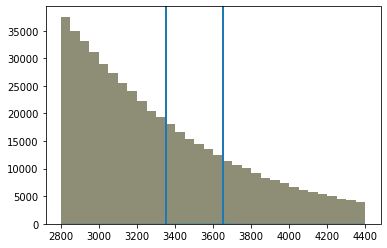

In [56]:
# Fit with full dataset, no cuts
#mask_sr=[3,4]
#def fit_func(y,p0,p1,p2,p3,p4,p5,p6,p7):
#    return np.exp(p0+p1*y+p2*y**2+p3*y**3+p4*y**4+p5*y**5+p6*y**6+p7*y**7)
#def fit_func(x,p0,p1,p2,p3,p4,p5,p6):
#    return (p3+p4*x+p5*x**2+p6*x**3)*skewnorm.pdf((x-p0)/p1,p2)\
#def fit_func(x,p0,p1,p2,p3,p4):
#    return p0*(1-x)**(p1+p4*(np.log(1-x)))/(x**(p2+p3*np.log(x)))

def fit_func(x,p0,p1):
    return p0+p1*x

#mask_sr=[4,5]
#mask_sr=[11,12,13,14,15,16]
pvallist_cut_sig=[]
pvallist_cut_sig2=[]
info_m500_cut_5 = []
info_m300_cut_5 = []
SIC_info_m500_cut_5 = []
SIC_info_m300_cut_5 = []

nbins=32
#mask_sr=[7,8,9,10,11,12]
#mask_sr=[9,10,11,12,13,14]
mask_sr=[11,12,13,14,15,16]
mask_sb=[x for x in range(nbins) if x not in mask_sr] 

nback = len(mjj_bg)

for nsig in range(10,895,15):
    print(nsig)
    
    ##########  m = 500 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig_raw,bins,_=plt.hist(mjj_sig[:nsig],range=[2800,4400],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.99)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig_final_avg[:nsig][(mjj_sig[:nsig] > 3350) & (mjj_sig[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_5_mse_m500 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m500 = np.abs(SIC_m500 - maxsiccut_sig).argmin()
    #eff_m500 = tpr500[:up_bound_m500][np.abs(SIC_m500[:up_bound_m500] - cut_5_mse_m500).argmin()]
    
    eff_m500 = tpr500[np.abs(thresh_m500 - cut_5_mse_m500).argmin()]
    SIC_01_percent_m500 = SIC_m500[np.abs(thresh_m500 - cut_5_mse_m500).argmin()]
    
    #print('mse threshold: %.5f' % cut_5_mse_m500)
    
    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_5_mse_m500],range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig,bins,_=plt.hist(mjj_sig[:nsig][mse_sig_final_avg[:nsig]>cut_5_mse_m500],range=[2800,4400],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])

    # After cut: define the total number of events (s+b) in each SR bin, and the statistical error in each SR bin
    ydata=(counts_bg+counts_sig).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')

    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    # Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m500 = (Safter + Bafter)/(Sinit + Binit)*100
    
    print(cut_5_mse_m500)
    
    info_m500_cut_5.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m500])
    SIC_info_m500_cut_5.append([S_B, eff_m500, SIC_01_percent_m500])
    
    
    ##########  m = 300 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig2_raw,bins,_=plt.hist(mjj_sig2[:nsig],range=[2800,4400],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig2_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.99)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig2_final_avg[:nsig][(mjj_sig2[:nsig] > 3350) & (mjj_sig2[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_5_mse_m300 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m300 = np.abs(SIC_m300 - maxsiccut_sig).argmin()
    #eff_m300 = tpr300[:up_bound_m300][np.abs(SIC_m300[:up_bound_m300] - cut_5_mse_m300).argmin()]
    
    eff_m300 = tpr300[np.abs(thresh_m300 - cut_5_mse_m300).argmin()]
    SIC_01_percent_m300 = SIC_m300[np.abs(thresh_m300 - cut_5_mse_m300).argmin()]

    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_5_mse_m300],range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig2,bins,_=plt.hist(mjj_sig2[:nsig][mse_sig2_final_avg[:nsig]>cut_5_mse_m300],range=[2800,4400],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig2[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])
    
    # After cut: define the total number of events (s+b) in each bin, and the statistical error in each bin
    ydata=(counts_bg+counts_sig2).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig2).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')
    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    #Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig2.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m300 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m300_cut_5.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m300])
    SIC_info_m300_cut_5.append([S_B, eff_m300, SIC_01_percent_m300])
    
# Transform lists to arrays
info_m500_cut_5 = np.array(info_m500_cut_5)
info_m300_cut_5 = np.array(info_m300_cut_5)
SIC_info_m500_cut_5 = np.array(SIC_info_m500_cut_5)
SIC_info_m300_cut_5 = np.array(SIC_info_m300_cut_5)

In [57]:
print('Event selection for m500: %.2f%%' % selection_m500)
print('Event selection for m300: %.2f%%' % selection_m300)

Event selection for m500: 1.00%
Event selection for m300: 1.00%


In [58]:
print('Signal efficiency for this cut on m500:\n%s\n' % SIC_info_m500_cut_5[:,1])
print('Signal efficiency for this cut on m300:\n%s' % SIC_info_m300_cut_5[:,1])

Signal efficiency for this cut on m500:
[0.29990287 0.29901247 0.29809894 0.2979833  0.29741668 0.29716228
 0.29676912 0.29667661 0.29648003 0.29572839 0.29519647 0.29465298
 0.29459516 0.29441014 0.29388978 0.29343879 0.2926409  0.29249058
 0.29227087 0.29205116 0.29191239 0.29147298 0.29087167 0.28987719
 0.28936839 0.28927589 0.28868614 0.28851269 0.28816578 0.28683596
 0.28669719 0.28629247 0.28528643 0.28451167 0.28434978 0.28374847
 0.28267305 0.28225676 0.28189829 0.28164389 0.28062629 0.28011749
 0.27952774 0.27888018 0.27851014 0.27793196 0.27748098 0.27712251
 0.27645181 0.27578112 0.27554985 0.27544578 0.27485603 0.27440505
 0.27391938 0.27366498 0.27335276 0.27261269 0.27228891]

Signal efficiency for this cut on m300:
[0.24748901 0.24671554 0.2464353  0.24615505 0.24552731 0.24525827
 0.24496682 0.24496682 0.24417093 0.24415972 0.24415972 0.24392431
 0.24385705 0.24364407 0.24327415 0.24308358 0.24308358 0.24254551
 0.24197381 0.24181688 0.24153663 0.24132365 0.240808   0.

In [59]:
print('SIC value for this cut on m500:\n%s\n' % SIC_info_m500_cut_5[:,2])
print('SIC value for this cut on m300:\n%s' % SIC_info_m300_cut_5[:,2])

SIC value for this cut on m500:
[3.016109   3.01453963 3.01905828 3.01809029 3.01886793 3.02131214
 3.02200764 3.02318439 3.02933905 3.03465115 3.03954707 3.04395593
 3.04159488 3.04394562 3.04799707 3.04702304 3.04965806 3.04966313
 3.05095657 3.05433212 3.05612669 3.05694428 3.05862079 3.05783236
 3.05809206 3.06147595 3.06672621 3.07016136 3.07151829 3.07224559
 3.07258646 3.07547585 3.06925737 3.06681543 3.06946374 3.06927767
 3.07361961 3.0756008  3.07963083 3.08089968 3.0817056  3.08046705
 3.08517306 3.08709708 3.08784653 3.08941608 3.09333314 3.09517896
 3.09714485 3.09444662 3.09830032 3.10062865 3.10113742 3.10290701
 3.10549418 3.10992588 3.10877424 3.10660595 3.11047328]

SIC value for this cut on m300:
[2.48911486 2.48888034 2.4892466  2.49053262 2.48733825 2.48763066
 2.48810852 2.48810852 2.48779589 2.48794871 2.48794871 2.49058368
 2.49043864 2.49448891 2.4946322  2.4973629  2.4973629  2.4987767
 2.50241823 2.4991804  2.50034387 2.499887   2.50124995 2.49858802
 2.49935

In [60]:
print('Threshold based on the SIC curve: mse = %.3f' % cut_5_mse_m500)
print('Threshold based on the SIC curve: mse = %.3f' % cut_5_mse_m300)

Threshold based on the SIC curve: mse = 1.739
Threshold based on the SIC curve: mse = 1.723


Text(0, 0.5, 'p value')

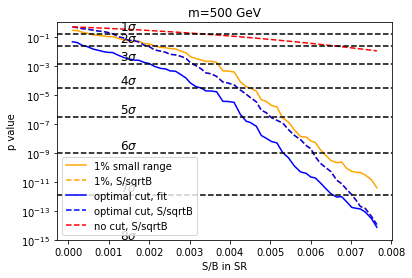

In [61]:
# Make plot
plt.plot(info_m500_cut_3[:,0], info_m500_cut_3[:,3], label='1% small range',color='orange')
plt.plot(info_m500_cut_3[:,0], info_m500_cut_3[:,5], label='1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m500_cut_5[:,0], info_m500_cut_5[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m500_cut_5[:,0], info_m500_cut_5[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m500_cut_5[:,0], info_m500_cut_5[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=500 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

Text(0, 0.5, 'p value')

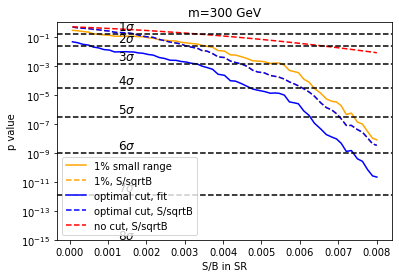

In [62]:
# Make plot
plt.plot(info_m300_cut_3[:,0], info_m300_cut_3[:,3], label='1% small range',color='orange')
plt.plot(info_m300_cut_3[:,0], info_m300_cut_3[:,5], label='1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m300_cut_5[:,0], info_m300_cut_5[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m300_cut_5[:,0], info_m300_cut_5[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m300_cut_5[:,0], info_m300_cut_5[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=300 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

In [63]:
# Check the fraction of selected events in the SR for each benchmarks for the m500 signal
info_m500_cut_5[:,-1]

array([0.99866182, 0.99854034, 0.99842993, 0.99829748, 0.99814299,
       0.99801061, 0.99788929, 0.99888399, 0.99877363, 0.99864123,
       0.99848681, 0.99838756, 0.99823322, 0.998123  , 0.99800179,
       0.99786959, 0.99884112, 0.99868681, 0.9985656 , 0.99846644,
       0.99832326, 0.99820213, 0.99807003, 0.99795997, 0.99782793,
       0.99879836, 0.99867725, 0.99854517, 0.99841312, 0.99825911,
       0.99813813, 0.9979842 , 0.99783032, 0.99878868, 0.9986897 ,
       0.99853577, 0.99841487, 0.99829398, 0.99816215, 0.99803035,
       0.9978876 , 0.99884495, 0.99870213, 0.99854837, 0.99840563,
       0.99829586, 0.99818612, 0.99806542, 0.99791186, 0.9978022 ,
       0.99875842, 0.99863772, 0.99851705, 0.99838545, 0.99827581,
       0.99817715, 0.99805659, 0.9979032 , 0.99886941])

In [64]:
# Check the fraction of selected events in the SR for each benchmarks for the m300 signal
info_m300_cut_5[:,-1]

array([0.9986839 , 0.99855138, 0.99841889, 0.99826437, 0.99814299,
       0.99801061, 0.99786724, 0.99882881, 0.99869639, 0.99856401,
       0.99840961, 0.99829936, 0.99820015, 0.9980679 , 0.99796874,
       0.99781452, 0.99879703, 0.99864273, 0.99849949, 0.9983563 ,
       0.99820213, 0.99807003, 0.99793796, 0.99780593, 0.99875431,
       0.99863322, 0.99850115, 0.99835811, 0.99821511, 0.99805017,
       0.99789627, 0.99886568, 0.99871169, 0.99856875, 0.99841487,
       0.998283  , 0.99811821, 0.99796446, 0.99783271, 0.99883396,
       0.99870213, 0.99857033, 0.99844954, 0.99833977, 0.99819709,
       0.99806542, 0.99792283, 0.99885719, 0.99871453, 0.9985719 ,
       0.99845125, 0.99833062, 0.99819907, 0.99806755, 0.99791415,
       0.99888038, 0.99874882, 0.9986173 , 0.99850772])

In [23]:
###################################################################################################################
###################################################################################################################
##################################################               ##################################################
##################################################     Cut 6     ##################################################
##################################################               ##################################################
###################################################################################################################
###################################################################################################################

10
fit params:  [-25.12727961 152.51384774]
x_signal_cov:  [[18.77793266]]
Z SCORE:  1.0896952051272673
P VALUE:  0.13792371448802743
GOODNESS OF FIT  1.0878730757919233
2.4641576
fit params:  [-24.95416048 152.02973795]
x_signal_cov:  [[18.68728436]]
Z SCORE:  1.0583302712689666
P VALUE:  0.14495244838383692
GOODNESS OF FIT  1.0777175611965617
25
fit params:  [-24.81894636 151.05060314]
x_signal_cov:  [[18.58387367]]
Z SCORE:  1.1260571620551116
P VALUE:  0.1300706623706802
GOODNESS OF FIT  1.08074312620218
2.4686797
fit params:  [-25.12727961 152.51384774]
x_signal_cov:  [[18.77793266]]
Z SCORE:  1.0896952051272673
P VALUE:  0.13792371448802743
GOODNESS OF FIT  1.0878730757919233
40
fit params:  [-24.46382228 148.37474025]
x_signal_cov:  [[17.27278983]]
Z SCORE:  1.329098362835087
P VALUE:  0.09190776017584479
GOODNESS OF FIT  1.029555970078016
2.4770555
fit params:  [-25.12727961 152.51384774]
x_signal_cov:  [[18.77793266]]
Z SCORE:  1.0896952051272673
P VALUE:  0.13792371448802743


2.6025987
fit params:  [-24.08047428 141.39137563]
x_signal_cov:  [[12.80908418]]
Z SCORE:  2.2625426753212934
P VALUE:  0.01183194765051876
GOODNESS OF FIT  0.8637651116733084
385
fit params:  [-21.2473395  120.77296834]
x_signal_cov:  [[12.036876]]
Z SCORE:  3.9358183663812767
P VALUE:  4.1456833233533e-05
GOODNESS OF FIT  1.0333868610410575
2.604344
fit params:  [-23.78292311 140.02350209]
x_signal_cov:  [[12.43911852]]
Z SCORE:  2.2981399717847903
P VALUE:  0.010776911945211243
GOODNESS OF FIT  0.8415778184860238
400
fit params:  [-21.2473395  120.77296834]
x_signal_cov:  [[12.036876]]
Z SCORE:  3.9358183663812767
P VALUE:  4.1456833233533e-05
GOODNESS OF FIT  1.0333868610410575
2.604344
fit params:  [-23.78292311 140.02350209]
x_signal_cov:  [[12.43911852]]
Z SCORE:  2.2981399717847903
P VALUE:  0.010776911945211243
GOODNESS OF FIT  0.8415778184860238
415
fit params:  [-21.2473395  120.77296834]
x_signal_cov:  [[12.036876]]
Z SCORE:  3.9358183663812767
P VALUE:  4.1456833233533e-0

fit params:  [-21.3469128  113.14012391]
x_signal_cov:  [[7.52021367]]
Z SCORE:  5.7707112323090834
P VALUE:  3.946882265459806e-09
GOODNESS OF FIT  0.8645137024043837
2.7009263
fit params:  [-24.59666086 140.85688294]
x_signal_cov:  [[13.15681654]]
Z SCORE:  2.8028769359166152
P VALUE:  0.0025324495889241794
GOODNESS OF FIT  0.9478160851764953
745
fit params:  [-21.3469128  113.14012391]
x_signal_cov:  [[7.52021367]]
Z SCORE:  5.7707112323090834
P VALUE:  3.946882265459806e-09
GOODNESS OF FIT  0.8645137024043837
2.7009263
fit params:  [-24.59666086 140.85688294]
x_signal_cov:  [[13.15681654]]
Z SCORE:  2.8028769359166152
P VALUE:  0.0025324495889241794
GOODNESS OF FIT  0.9478160851764953
760
fit params:  [-21.61424468 114.37095392]
x_signal_cov:  [[7.43771499]]
Z SCORE:  5.846811401954778
P VALUE:  2.5054253116607583e-09
GOODNESS OF FIT  0.8507179434137763
2.6977203
fit params:  [-24.59666086 140.85688294]
x_signal_cov:  [[13.15681654]]
Z SCORE:  2.8028769359166152
P VALUE:  0.0025324

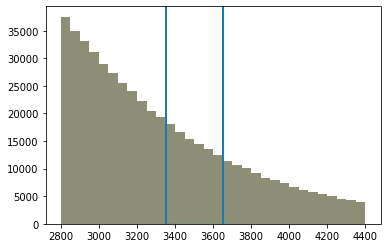

In [26]:
# Fit with full dataset, no cuts
#mask_sr=[3,4]
#def fit_func(y,p0,p1,p2,p3,p4,p5,p6,p7):
#    return np.exp(p0+p1*y+p2*y**2+p3*y**3+p4*y**4+p5*y**5+p6*y**6+p7*y**7)
#def fit_func(x,p0,p1,p2,p3,p4,p5,p6):
#    return (p3+p4*x+p5*x**2+p6*x**3)*skewnorm.pdf((x-p0)/p1,p2)\
#def fit_func(x,p0,p1,p2,p3,p4):
#    return p0*(1-x)**(p1+p4*(np.log(1-x)))/(x**(p2+p3*np.log(x)))

def fit_func(x,p0,p1):
    return p0+p1*x

#mask_sr=[4,5]
#mask_sr=[11,12,13,14,15,16]
pvallist_cut_sig=[]
pvallist_cut_sig2=[]
info_m500_cut_6 = []
info_m300_cut_6 = []
SIC_info_m500_cut_6 = []
SIC_info_m300_cut_6 = []

nbins=32
#mask_sr=[7,8,9,10,11,12]
#mask_sr=[9,10,11,12,13,14]
mask_sr=[11,12,13,14,15,16]
mask_sb=[x for x in range(nbins) if x not in mask_sr] 

nback = len(mjj_bg)

for nsig in range(10,895,15):
    print(nsig)
    
    ##########  m = 500 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig_raw,bins,_=plt.hist(mjj_sig[:nsig],range=[2800,4400],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 0.1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.999)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig_final_avg[:nsig][(mjj_sig[:nsig] > 3350) & (mjj_sig[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_6_mse_m500 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m500 = np.abs(SIC_m500 - maxsiccut_sig).argmin()
    #eff_m500 = tpr500[:up_bound_m500][np.abs(SIC_m500[:up_bound_m500] - cut_6_mse_m500).argmin()]
    
    eff_m500 = tpr500[np.abs(thresh_m500 - cut_6_mse_m500).argmin()]
    SIC_01_percent_m500 = SIC_m500[np.abs(thresh_m500 - cut_6_mse_m500).argmin()]
    
    #print('mse threshold: %.5f' % cut_6_mse_m500)
    
    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_6_mse_m500],range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig,bins,_=plt.hist(mjj_sig[:nsig][mse_sig_final_avg[:nsig]>cut_6_mse_m500],range=[2800,4400],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])

    # After cut: define the total number of events (s+b) in each SR bin, and the statistical error in each SR bin
    ydata=(counts_bg+counts_sig).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')

    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    # Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m500 = (Safter + Bafter)/(Sinit + Binit)*100
    
    print(cut_6_mse_m500)
    
    info_m500_cut_6.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m500])
    SIC_info_m500_cut_6.append([S_B, eff_m500, SIC_01_percent_m500])
    
    
    ##########  m = 300 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig2_raw,bins,_=plt.hist(mjj_sig2[:nsig],range=[2800,4400],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig2_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # Find the mse threshold above which only 0.1% of the SR events survive
    n_cut = int((Sinit + Binit)*0.999)
    mse_bg_SR = mse_bg_final_avg[(mjj_bg > 3350) & (mjj_bg < 3650)]
    mse_sg_SR = mse_sig2_final_avg[:nsig][(mjj_sig2[:nsig] > 3350) & (mjj_sig2[:nsig] < 3650)]
    mse_sorted = np.sort(np.concatenate((mse_bg_SR, mse_sg_SR), axis=0))
    cut_6_mse_m300 = mse_sorted[n_cut]
    
    # Calculate signal efficiency that corresponds to this threshold
    #up_bound_m300 = np.abs(SIC_m300 - maxsiccut_sig).argmin()
    #eff_m300 = tpr300[:up_bound_m300][np.abs(SIC_m300[:up_bound_m300] - cut_6_mse_m300).argmin()]
    
    eff_m300 = tpr300[np.abs(thresh_m300 - cut_6_mse_m300).argmin()]
    SIC_01_percent_m300 = SIC_m300[np.abs(thresh_m300 - cut_6_mse_m300).argmin()]

    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>cut_6_mse_m300],range=[2800,4400],bins=nbins,alpha=0.3)
    counts_sig2,bins,_=plt.hist(mjj_sig2[:nsig][mse_sig2_final_avg[:nsig]>cut_6_mse_m300],range=[2800,4400],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig2[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])
    
    # After cut: define the total number of events (s+b) in each bin, and the statistical error in each bin
    ydata=(counts_bg+counts_sig2).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig2).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')
    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    #Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig2.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m300 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m300_cut_6.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after, selection_m300])
    SIC_info_m300_cut_6.append([S_B, eff_m300, SIC_01_percent_m300])
    
# Transform lists to arrays
info_m500_cut_6 = np.array(info_m500_cut_6)
info_m300_cut_6 = np.array(info_m300_cut_6)
SIC_info_m500_cut_6 = np.array(SIC_info_m500_cut_6)
SIC_info_m300_cut_6 = np.array(SIC_info_m300_cut_6)

In [67]:
print('Event selection for m500: %.2f%%' % selection_m500)
print('Event selection for m300: %.2f%%' % selection_m300)

Event selection for m500: 0.10%
Event selection for m300: 0.10%


In [68]:
print('Signal efficiency for this cut on m500:\n%s\n' % SIC_info_m500_cut_6[:,1])
print('Signal efficiency for this cut on m300:\n%s' % SIC_info_m300_cut_6[:,1])

Signal efficiency for this cut on m500:
[0.09348042 0.09233562 0.09179213 0.09042762 0.08361664 0.08361664
 0.08347788 0.08347788 0.08347788 0.08242559 0.08221744 0.08101482
 0.08101482 0.08037882 0.07777701 0.07777701 0.07574181 0.07574181
 0.07574181 0.07574181 0.07518675 0.07518675 0.07490923 0.0738685
 0.0738685  0.07349846 0.07349846 0.07349846 0.07349846 0.0731053
 0.0731053  0.07296653 0.0710701  0.07097759 0.07097759 0.07097759
 0.06909272 0.06904646 0.06864174 0.06864174 0.06864174 0.06864174
 0.06400472 0.06383126 0.06291774 0.06291774 0.06291774 0.06291774
 0.06214297 0.06214297 0.06291774 0.06291774 0.06291774 0.06026966
 0.06026966 0.06016559 0.06016559 0.06016559 0.06016559]

Signal efficiency for this cut on m300:
[0.05366111 0.05322393 0.05322393 0.05208053 0.05164335 0.05164335
 0.05164335 0.05035423 0.05035423 0.05035423 0.05035423 0.05035423
 0.05035423 0.04554524 0.04554524 0.04554524 0.04554524 0.04554524
 0.04554524 0.04554524 0.04554524 0.04554524 0.04482782 0.04

In [69]:
print('SIC value for this cut on m500:\n%s\n' % SIC_info_m500_cut_6[:,2])
print('SIC value for this cut on m300:\n%s' % SIC_info_m300_cut_6[:,2])

SIC value for this cut on m500:
[3.07256398 3.07644446 3.0625351  3.06340861 2.87963739 2.87963739
 2.86662484 2.86662484 2.86662484 2.90145243 2.9370018  2.94046173
 2.94046173 2.93801416 2.95702533 2.95702533 2.9741723  2.9741723
 2.9361737  2.9361737  2.9463709  2.9463709  2.94323222 2.95278357
 2.95278357 2.97214629 2.97214629 2.97214629 2.94814759 2.95287027
 2.95287027 2.95685305 2.93647253 2.95707961 2.95707961 2.9346377
 2.9323184  2.93691663 2.97127783 2.97127783 2.97127783 2.97127783
 3.01975707 2.87496863 2.91619252 2.91619252 2.91619252 2.90932467
 2.9347341  2.9347341  2.90932467 2.90932467 2.90932467 2.88931411
 2.88931411 2.91546228 2.82757526 2.82757526 2.82757526]

SIC value for this cut on m300:
[1.75376834 1.75637461 1.75637461 1.74362209 1.7229354  1.7229354
 1.7229354  1.71294647 1.71294647 1.71294647 1.71294647 1.71294647
 1.71294647 1.57350732 1.57350732 1.57350732 1.57350732 1.57350732
 1.57350732 1.57350732 1.57350732 1.57350732 1.55390011 1.56142509
 1.5614250

In [70]:
print('Threshold based on the SIC curve: mse = %.3f' % cut_6_mse_m500)
print('Threshold based on the SIC curve: mse = %.3f' % cut_6_mse_m300)

Threshold based on the SIC curve: mse = 2.720
Threshold based on the SIC curve: mse = 2.556


Text(0, 0.5, 'p value')

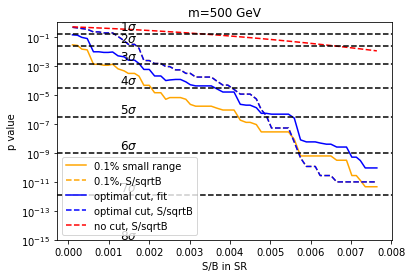

In [71]:
# Make plot
plt.plot(info_m500_cut_4[:,0], info_m500_cut_4[:,3], label='0.1% small range',color='orange')
plt.plot(info_m500_cut_4[:,0], info_m500_cut_4[:,5], label='0.1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m500_cut_6[:,0], info_m500_cut_6[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m500_cut_6[:,0], info_m500_cut_6[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m500_cut_6[:,0], info_m500_cut_6[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=500 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

Text(0, 0.5, 'p value')

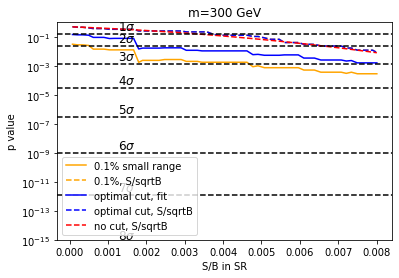

In [72]:
# Make plot
plt.plot(info_m300_cut_4[:,0], info_m300_cut_4[:,3], label='0.1% small range',color='orange')
plt.plot(info_m300_cut_4[:,0], info_m300_cut_4[:,5], label='0.1%, S/sqrtB',color='orange',ls='dashed')

plt.plot(info_m300_cut_6[:,0], info_m300_cut_6[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m300_cut_6[:,0], info_m300_cut_6[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m300_cut_6[:,0], info_m300_cut_6[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')

for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=300 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

In [73]:
# Check the fraction of selected events in the SR for each benchmarks for the m500 signal
info_m500_cut_6[:,-1]

array([0.09842846, 0.09841649, 0.09840561, 0.09839255, 0.09837733,
       0.09836428, 0.09835232, 0.09834145, 0.09833059, 0.09831755,
       0.09830235, 0.09829258, 0.09827739, 0.09826653, 0.0982546 ,
       0.09824159, 0.09822857, 0.0982134 , 0.09820148, 0.09819173,
       0.09817765, 0.09816573, 0.09815274, 0.09814192, 0.09812893,
       0.09811595, 0.09810406, 0.09809108, 0.09807811, 0.09806298,
       0.0980511 , 0.09803598, 0.09802086, 0.09800683, 0.09799712,
       0.09798201, 0.09797015, 0.09795829, 0.09794535, 0.09793242,
       0.09791841, 0.09790441, 0.09789041, 0.09787534, 0.09786134,
       0.09785059, 0.09783983, 0.097828  , 0.09781295, 0.0978022 ,
       0.09888697, 0.09887502, 0.09886307, 0.09885004, 0.09883919,
       0.09882942, 0.09881748, 0.0988023 , 0.09878928])

In [74]:
# Check the fraction of selected events in the SR for each benchmarks for the m300 signal
info_m300_cut_6[:,-1]

array([0.09843064, 0.09841758, 0.09840452, 0.09838929, 0.09837733,
       0.09836428, 0.09835015, 0.09833602, 0.09832299, 0.09830995,
       0.09829475, 0.0982839 , 0.09827413, 0.09826111, 0.09825135,
       0.09823616, 0.09822424, 0.09820906, 0.09819498, 0.0981809 ,
       0.09816573, 0.09815274, 0.09813976, 0.09812677, 0.09811163,
       0.09809973, 0.09808676, 0.09807271, 0.09805866, 0.09804246,
       0.09802734, 0.09801438, 0.09799927, 0.09798525, 0.09797015,
       0.09795721, 0.09794104, 0.09792595, 0.09791302, 0.09790333,
       0.09789041, 0.09787749, 0.09786565, 0.09785489, 0.0978409 ,
       0.097828  , 0.09781402, 0.09889675, 0.09888263, 0.0988685 ,
       0.09885656, 0.09884462, 0.09883159, 0.09881857, 0.09880338,
       0.09879037, 0.09877736, 0.09876435, 0.09875351])

In [75]:
# Summary of scenarios:
# 
# 0) SIC: fit range [3000, 4000]                                              |  sigma = 0.89 for S/B = 0
# 1) Cut 1: 1% cut on all the events, fit range [3000, 4000]    |  Fine       |  sigma = 0.68 for S/B = 0
# 2) Cut 2: 0.1% cut on all the events, fit range [3000, 4000]  |  Super bad  |  sigma = 2.10 for S/B = 0
# 3) Cut 3: 1% cut on SR events, fit range [3000, 4000]         |  Best one   |  sigma = 0.56 for S/B = 0
# 4) Cut 4: 0.1% cut on SR events, fit range [3000, 4000]       |  Super bad  |  sigma = 1.87 for S/B = 0
# 5) Cut 5: 1% cut on SR events, fit range [2800, 4400]         |  Bad        |  sigma = 1.67 for S/B = 0
# 6) Cut 6: 0.1% cut on SR events, fit range [2800, 4400]       |  Best one   |  sigma = 1.06 for S/B = 0
# 

In [76]:
#######################################################################################################
##########################################   Save to file   ###########################################
#######################################################################################################    

save_path = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/AE_new_data/'

# Create dataset and classes to store important information
file_m500 = h5py.File(save_path + 'AE_cuts_fit_SIC_info_m500.hdf5', 'w')

# Save mse distribution and AUC
cut_1_percent_info_tofile = file_m500.create_dataset('cut_1_percent', SIC_info_m500_cut_3.shape, dtype='f8')
cut_01_percent_info_tofile = file_m500.create_dataset('cut_01_percent', SIC_info_m500_cut_6.shape, dtype='f8')

# Fill dataset
cut_1_percent_info_tofile[:] = SIC_info_m500_cut_3
cut_01_percent_info_tofile[:] = SIC_info_m500_cut_6

file_m500.close()


# Create dataset and classes to store important information
file_m300 = h5py.File(save_path + 'AE_cuts_fit_SIC_info_m300.hdf5', 'w')

# Save mse distribution and AUC
cut_1_percent_info_tofile = file_m300.create_dataset('cut_1_percent', SIC_info_m300_cut_3.shape, dtype='f8')
cut_01_percent_info_tofile = file_m300.create_dataset('cut_01_percent', SIC_info_m300_cut_6.shape, dtype='f8')

# Fill dataset
cut_1_percent_info_tofile[:] = SIC_info_m300_cut_3
cut_01_percent_info_tofile[:] = SIC_info_m300_cut_6

file_m300.close()

In [77]:
#######################################################################################################
##########################################   Save to file   ###########################################
#######################################################################################################    

save_path = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/AE_new_data/'

# Create dataset and classes to store important information
file_m500 = h5py.File(save_path + 'AE_pvalues_from_fit_info_m500.hdf5', 'w')

# Save mse distribution and AUC
fit_cut_1_info_tofile = file_m500.create_dataset('fit_m500_cut_1', info_m500_cut_1.shape, dtype='f8')
fit_cut_2_info_tofile = file_m500.create_dataset('fit_m500_cut_2', info_m500_cut_2.shape, dtype='f8')
fit_cut_3_info_tofile = file_m500.create_dataset('fit_m500_cut_3', info_m500_cut_3.shape, dtype='f8')
fit_cut_4_info_tofile = file_m500.create_dataset('fit_m500_cut_4', info_m500_cut_4.shape, dtype='f8')
fit_cut_5_info_tofile = file_m500.create_dataset('fit_m500_cut_5', info_m500_cut_5.shape, dtype='f8')
fit_cut_6_info_tofile = file_m500.create_dataset('fit_m500_cut_6', info_m500_cut_6.shape, dtype='f8')

# Fill dataset
fit_cut_1_info_tofile[:] = info_m500_cut_1
fit_cut_2_info_tofile[:] = info_m500_cut_2
fit_cut_3_info_tofile[:] = info_m500_cut_3
fit_cut_4_info_tofile[:] = info_m500_cut_4
fit_cut_5_info_tofile[:] = info_m500_cut_5
fit_cut_6_info_tofile[:] = info_m500_cut_6

file_m500.close()


# Create dataset and classes to store important information
file_m300 = h5py.File(save_path + 'AE_pvalues_from_fit_info_m300.hdf5', 'w')

# Save mse distribution and AUC
fit_cut_1_info_tofile = file_m300.create_dataset('fit_m300_cut_1', info_m300_cut_1.shape, dtype='f8')
fit_cut_2_info_tofile = file_m300.create_dataset('fit_m300_cut_2', info_m300_cut_2.shape, dtype='f8')
fit_cut_3_info_tofile = file_m300.create_dataset('fit_m300_cut_3', info_m300_cut_3.shape, dtype='f8')
fit_cut_4_info_tofile = file_m300.create_dataset('fit_m300_cut_4', info_m300_cut_4.shape, dtype='f8')
fit_cut_5_info_tofile = file_m300.create_dataset('fit_m300_cut_5', info_m300_cut_5.shape, dtype='f8')
fit_cut_6_info_tofile = file_m300.create_dataset('fit_m300_cut_6', info_m300_cut_6.shape, dtype='f8')

# Fill dataset
fit_cut_1_info_tofile[:] = info_m300_cut_1
fit_cut_2_info_tofile[:] = info_m300_cut_2
fit_cut_3_info_tofile[:] = info_m300_cut_3
fit_cut_4_info_tofile[:] = info_m300_cut_4
fit_cut_5_info_tofile[:] = info_m300_cut_5
fit_cut_6_info_tofile[:] = info_m300_cut_6

file_m300.close()